In [1]:
import sys
import os
import subprocess

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import re
# import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
# from tqdm import tqdm
import traceback
import hashlib

import event_processing_v3
import postgresql_v3_event_storage
import dataset_query_functions_v3

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
# from event_recognition_efficiency_v3 import *
# import supervised_classification as supc

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Welcome to JupyROOT 6.13/02


In [2]:
# simu_signal_event_table='spb_processing_v3_simu_signal.event_uniq_3_1_10001'
simu_signal_event_table='spb_processing_v3_simu_signal.event'
sql_where_clauses_str = " AND program_version='3.1'"

In [3]:
data_snippents_dir = 'ver3_simu_signal_data_snippets'
os.makedirs(data_snippents_dir, exist_ok=True)

In [4]:
event_v3_storage_provider = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_signal.ini'), table_names_version='ver3',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_v3.EventProcessingV3
)

query_functions = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider)

In [5]:
event_v3_storage_provider.data_table_name

'spb_processing_v3_simu_signal.event'

In [6]:
columns_for_analysis_dict = query_functions.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=( 
#         ('^$','^gtu_in_packet$'), '.+_seed_coords_[xy].*', 
#         ('.*','^event_id$'),('^$','^program_version$'), ('^$','^timestamp$'), ('^$','^global_gtu$'), ('^$','^packet_id$'),
#         ('^$','^source_data_type_num$'),('^$','^config_info_id$'), ('^$','^source_file_.+$'),
#         '^(trg|alt|orig|bg)\d*_.+$','.*dbscan.*','.*line_coord.*',
#         '.*proc3.*','.*proc2.*',
#         '^trg_box_per_gtu_.+', '^trg_ec_per_gtu_.+', '^n_persist_.+', '^sum_l1_pdm_.+',
        
#         '.+_norm_sum$', '.+_std$', '.+_mean_gz$', '.+_std_gz$', '.+_mean$',
# #         'proc1_((x|gtu)_[xy]|gtu_[xy])_(width|height|mean|area)$',
#         'proc1_gtu_y'
        
#         '(x_y|gtu_(x|y))_clusters_.+clu_.+$',
        
#         'line_coord_\d+_[xy]'
        '^.+$',
    ),
    
    default_excluded_columns_re_list=[],
#     for debugging selection
    included_columns_re_list=[('^$','^source_file_acquisition_full$'), 
                              ('^$','gtu_in_packet'), ('^$','event_id'), ('^$','num_gtu'),
                             
                              '.*orig_x_y_max',
                              '.*orig_x_y_mean_gz',
                              '.*proc1_(x|gtu)_(x|y)_clusters_count',
                              '.*proc1_(x|gtu)_(x|y)_clusters_sizes_mean$',
                              '.*proc1_(x|gtu)_(x|y)_clusters_sizes_max$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr\d+_max_clu_major_line_phi$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr\d+_max_clu_major_line_rho$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr\d+_major_line_phi$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr\d+_major_line_rho$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_size_clu_height$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_size_clu_width$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_sum_clu_height$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_sum_clu_width$',
                              '.*proc1_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_count',
                              '.*proc1_(x|gtu)_(x|y)_clusters_count'
                             ]
    
)

In [7]:
#import pprint
split_columns_for_analysis_dict = query_functions.split_to_smaller_dicts(columns_for_analysis_dict,50000)
#print(select_clause_str)
for i,g in enumerate(split_columns_for_analysis_dict):
    tot_items = 0
    for k,vl in g.items():
        tot_items += len(vl)
    print(i,tot_items)
    
    for t, vl in g.items():
        sys.stdout.write(t)
        sys.stdout.write('\n\t- ')
#         print('\t'+(', '.join(vl)))
        print('\n\t- '.join(vl))
        print()
    
    print('-'*60)

0 96
spb_processing_v3_simu_signal.event
	- event_id
	- source_file_acquisition_full
	- gtu_in_packet
	- num_gtu

spb_processing_v3_simu_signal.event_orig_x_y
	- max
	- mean_gz

spb_processing_v3_simu_signal.event_proc1_x_y_clusters
	- count
	- sizes_max
	- sizes_mean

spb_processing_v3_simu_signal.event_proc1_gtu_x_clusters
	- count
	- sizes_max
	- sizes_mean

spb_processing_v3_simu_signal.event_proc1_gtu_y_clusters
	- count
	- sizes_max
	- sizes_mean

spb_processing_v3_simu_signal.event_proc1_x_y_hough_peak_thr1
	- major_line_phi
	- major_line_rho
	- max_clu_major_line_phi
	- max_clu_major_line_rho
	- line_clusters_count
	- line_clusters_max_size_clu_width
	- line_clusters_max_size_clu_height
	- line_clusters_max_sum_clu_width
	- line_clusters_max_sum_clu_height

spb_processing_v3_simu_signal.event_proc1_x_y_hough_peak_thr2
	- major_line_phi
	- major_line_rho
	- max_clu_major_line_phi
	- max_clu_major_line_rho
	- line_clusters_count
	- line_clusters_max_size_clu_width
	- line_cluster

In [8]:
current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

select_clause_str, joined_tables_list = \
    query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
join_clauses_str = \
    query_functions.get_query_clauses__join(joined_tables_list)
where_clauses_str = sql_where_clauses_str
    
events_selection_query = query_functions.get_events_selection_query_plain(
    source_data_type_num=10001,
    select_additional=select_clause_str, join_additional=join_clauses_str,
    where_additional=where_clauses_str,
    order_by='{data_table_name}.event_id', limit=100000, offset=0,
    base_select='',
    data_table_name_overwrite=simu_signal_event_table)

In [9]:
print(events_selection_query)


    SELECT 
        
        spb_processing_v3_simu_signal.event.event_id, spb_processing_v3_simu_signal.event.source_file_acquisition_full, spb_processing_v3_simu_signal.event.gtu_in_packet, spb_processing_v3_simu_signal.event.num_gtu, spb_processing_v3_simu_signal.event_orig_x_y.max AS orig_x_y_max, spb_processing_v3_simu_signal.event_orig_x_y.mean_gz AS orig_x_y_mean_gz, spb_processing_v3_simu_signal.event_proc1_x_y_clusters.count AS proc1_x_y_clusters_count, spb_processing_v3_simu_signal.event_proc1_x_y_clusters.sizes_max AS proc1_x_y_clusters_sizes_max, spb_processing_v3_simu_signal.event_proc1_x_y_clusters.sizes_mean AS proc1_x_y_clusters_sizes_mean, spb_processing_v3_simu_signal.event_proc1_gtu_x_clusters.count AS proc1_gtu_x_clusters_count, spb_processing_v3_simu_signal.event_proc1_gtu_x_clusters.sizes_max AS proc1_gtu_x_clusters_sizes_max, spb_processing_v3_simu_signal.event_proc1_gtu_x_clusters.sizes_mean AS proc1_gtu_x_clusters_sizes_mean, spb_processing_v3_simu_signal.even

In [10]:
data_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [11]:
def angle_difference(a1, a2):
    r = np.abs(a1 - a2) % (2*np.pi)
    if r >= np.pi:
        r = 2*np.pi - r
    return r

def normalize_phi(phi):
    norm_phi = np.arctan2(np.sin(phi), np.cos(phi))
    if norm_phi < 0:
        norm_phi = (2*np.pi + norm_phi)
    # norm_phi = (2*np.pi + norm_phi) * (norm_phi < 0) + norm_phi * (norm_phi > 0)
    return norm_phi

def smaller_angle_difference(a1, a2):
    d = angle_difference(a1,a2)
    if d > np.pi/2:
        d = np.pi - d
    return normalize_phi(d)

def add_diff_columns(events_df, do_copy=False):
    if do_copy:
        events_df_w_diff = events_df.copy()
    else:
        events_df_w_diff = events_df
    events_df_w_diff['proc1_gtu_y_gtu_x_hough_peak_thr1_major_line_phi_diff'] = events_df.apply(lambda x: smaller_angle_difference(x['proc1_gtu_x_hough_peak_thr1_major_line_phi'], x['proc1_gtu_y_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['proc1_gtu_y_hough_peak_thr1_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['proc1_gtu_y_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['proc1_gtu_y_hough_peak_thr1_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['proc1_gtu_y_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['proc1_gtu_x_hough_peak_thr1_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['proc1_gtu_x_hough_peak_thr1_major_line_phi']), axis=1)
    events_df_w_diff['proc1_gtu_x_hough_peak_thr1_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['proc1_gtu_x_hough_peak_thr1_major_line_phi']), axis=1)

add_diff_columns(data_df)

event_id 475757243.5


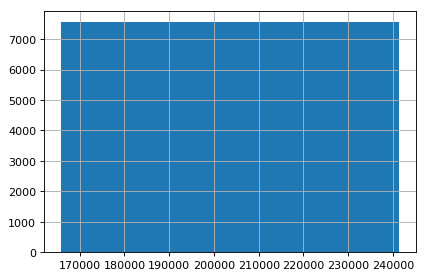

orig_x_y_max 21.93228865901877


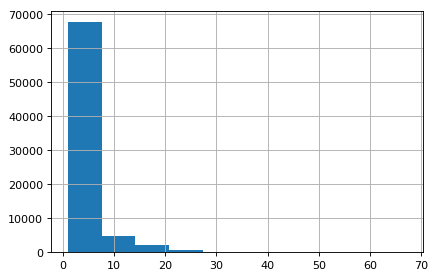

orig_x_y_mean_gz 0.6019703799324774


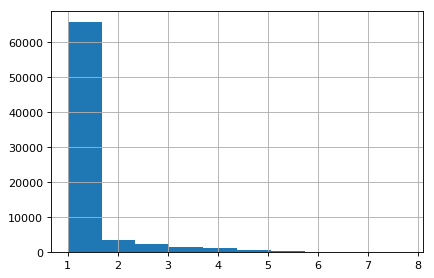

proc1_x_y_clusters_count 3.3677743869169725


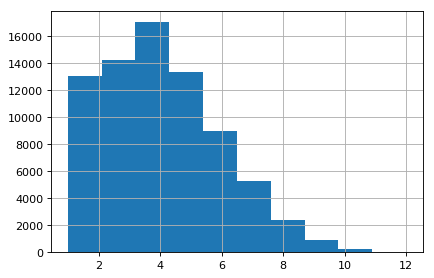

proc1_x_y_clusters_sizes_max 1713.1325427639601


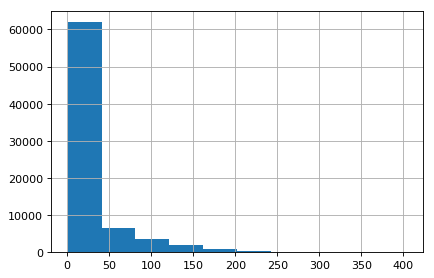

proc1_x_y_clusters_sizes_mean 779.6422377580026


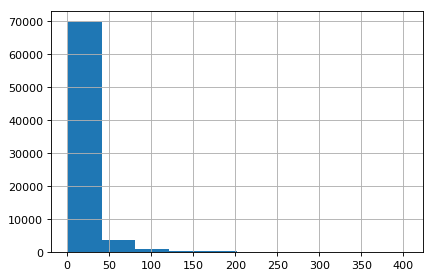

proc1_gtu_x_clusters_count 1.5234142368284322


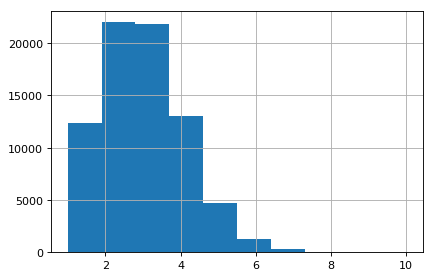

proc1_gtu_x_clusters_sizes_max 714.4049287537215


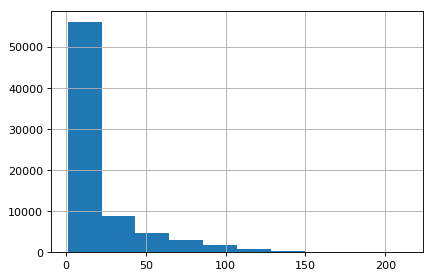

proc1_gtu_x_clusters_sizes_mean 440.9633042940112


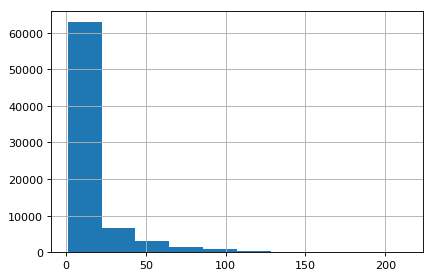

proc1_gtu_y_clusters_count 1.5187127301182342


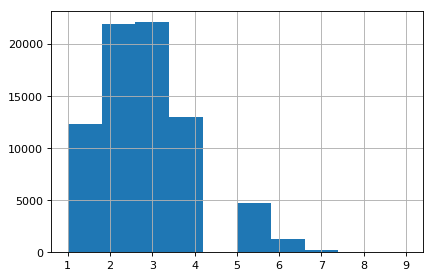

proc1_gtu_y_clusters_sizes_max 706.6622928162944


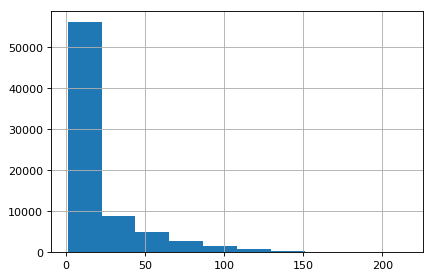

proc1_gtu_y_clusters_sizes_mean 442.5720723152994


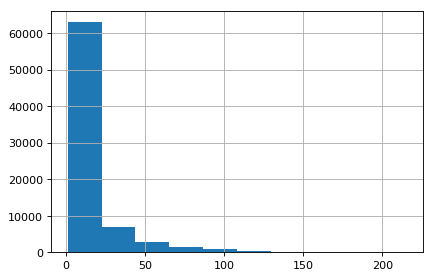

proc1_x_y_hough_peak_thr1_major_line_phi 4.525683398223357


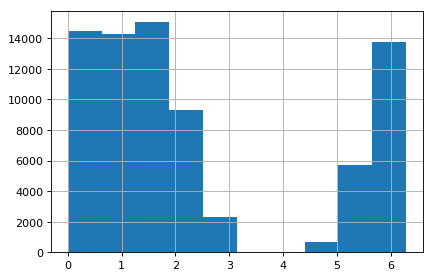

proc1_x_y_hough_peak_thr1_major_line_rho 189.4825964941011


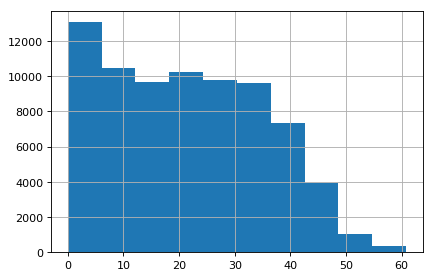

proc1_x_y_hough_peak_thr1_max_clu_major_line_phi 5.242210348600447


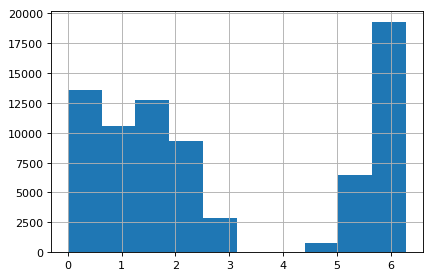

proc1_x_y_hough_peak_thr1_max_clu_major_line_rho 203.68976882109772


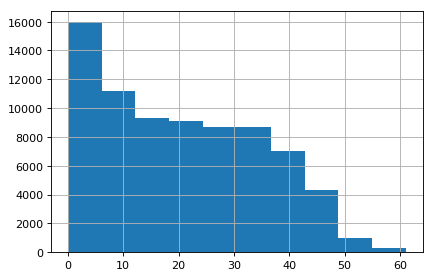

proc1_x_y_hough_peak_thr1_line_clusters_count 2.776709011548372


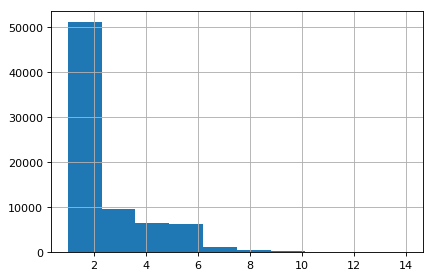

proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width 851.9303717778794


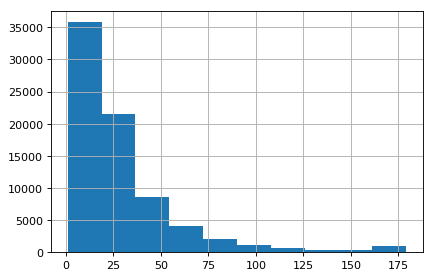

proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height 553.8752890480139


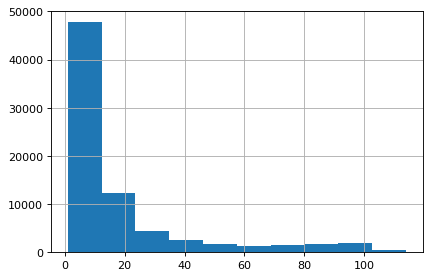

proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width 851.9303717778794


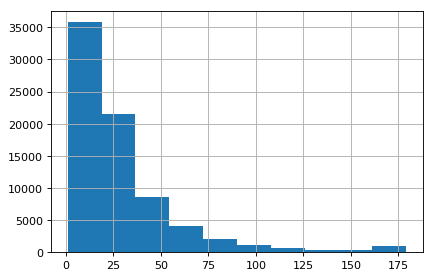

proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height 553.8752890480139


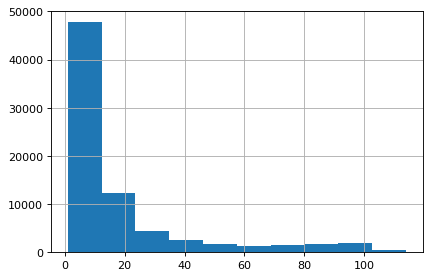

proc1_x_y_hough_peak_thr2_major_line_phi 4.5133563750101295


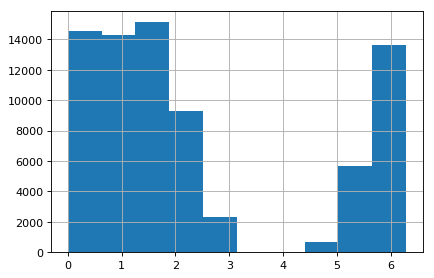

proc1_x_y_hough_peak_thr2_major_line_rho 195.5780823269458


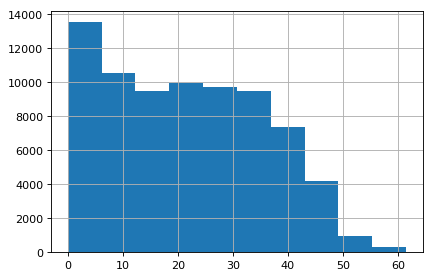

proc1_x_y_hough_peak_thr2_max_clu_major_line_phi 5.290540532241142


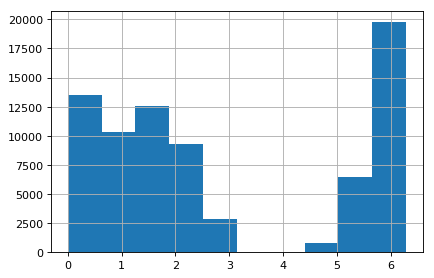

proc1_x_y_hough_peak_thr2_max_clu_major_line_rho 204.93973295175385


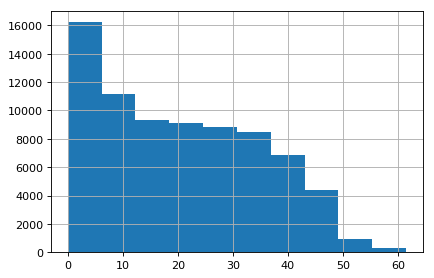

proc1_x_y_hough_peak_thr2_line_clusters_count 1.8204106014858557


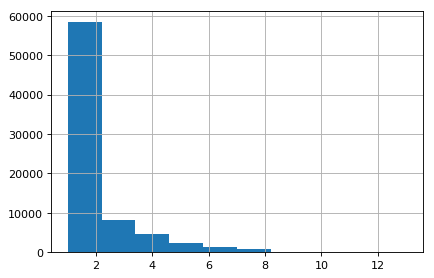

proc1_x_y_hough_peak_thr2_line_clusters_max_size_clu_width 476.17910828762444


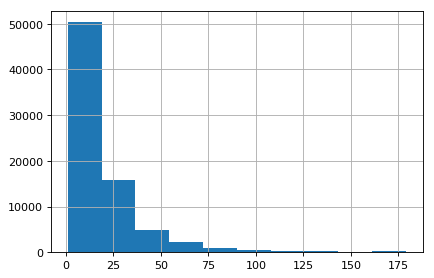

proc1_x_y_hough_peak_thr2_line_clusters_max_size_clu_height 402.2724452369372


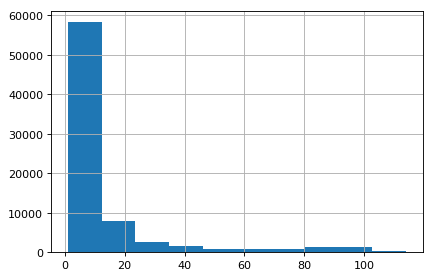

proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width 476.17910828762444


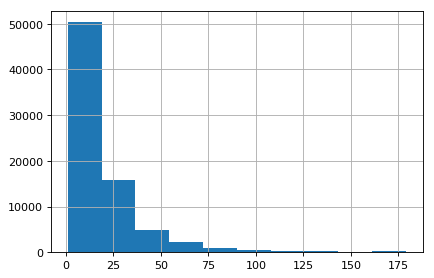

proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_height 402.2724452369372


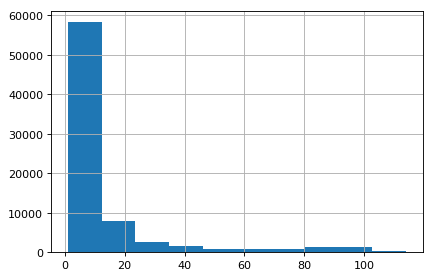

proc1_x_y_hough_peak_thr3_major_line_phi 4.523265086071862


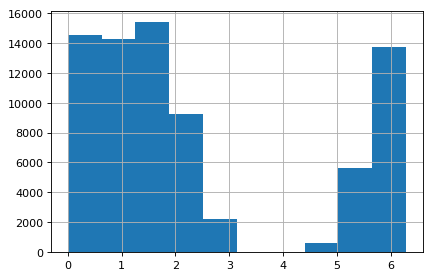

proc1_x_y_hough_peak_thr3_major_line_rho 199.43456172771496


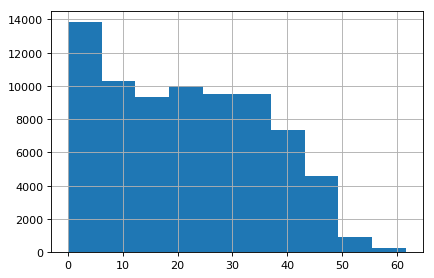

proc1_x_y_hough_peak_thr3_max_clu_major_line_phi 5.319384024812854


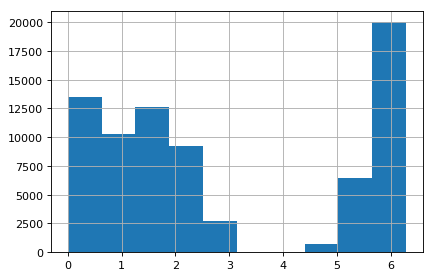

proc1_x_y_hough_peak_thr3_max_clu_major_line_rho 205.59380921811137


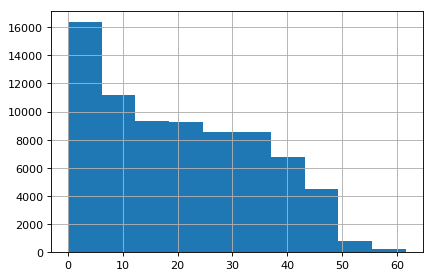

proc1_x_y_hough_peak_thr3_line_clusters_count 1.4146577519645918


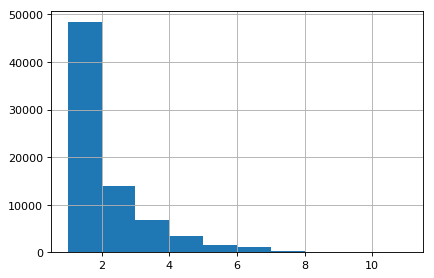

proc1_x_y_hough_peak_thr3_line_clusters_max_size_clu_width 313.380503374015


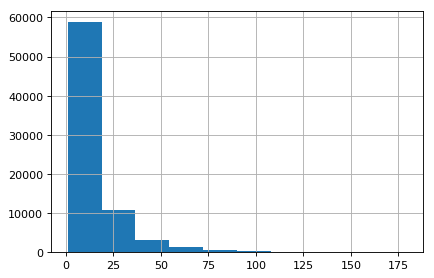

proc1_x_y_hough_peak_thr3_line_clusters_max_size_clu_height 295.0400484650491


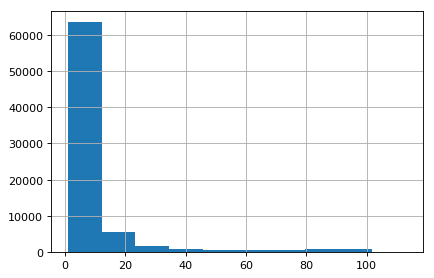

proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width 313.380503374015


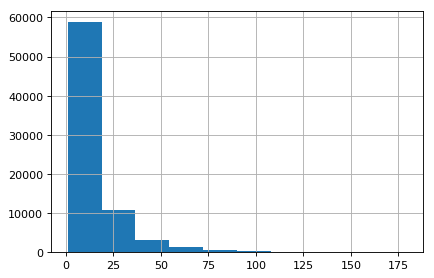

proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_height 295.0400484650491


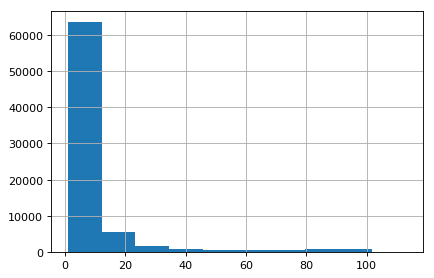

proc1_gtu_x_hough_peak_thr1_major_line_phi 6.943230324997053


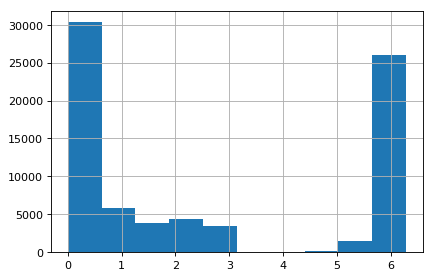

proc1_gtu_x_hough_peak_thr1_major_line_rho 93.90007601775983


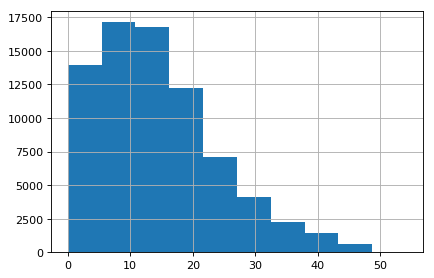

proc1_gtu_x_hough_peak_thr1_max_clu_major_line_phi 7.441431045238047


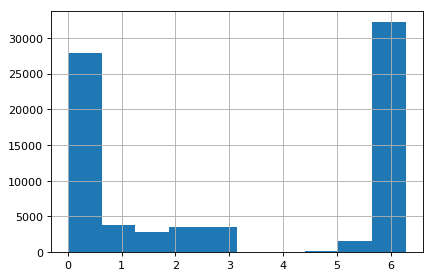

proc1_gtu_x_hough_peak_thr1_max_clu_major_line_rho 88.24265781399424


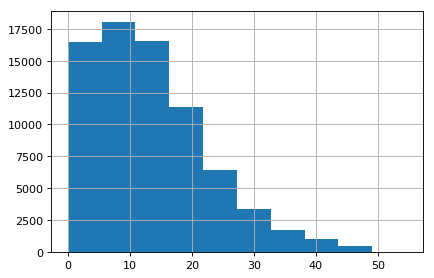

proc1_gtu_x_hough_peak_thr1_line_clusters_count 1.9792167318060476


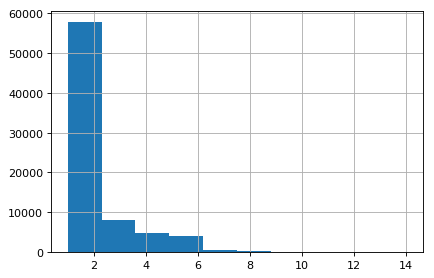

proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width 423.93360246820384


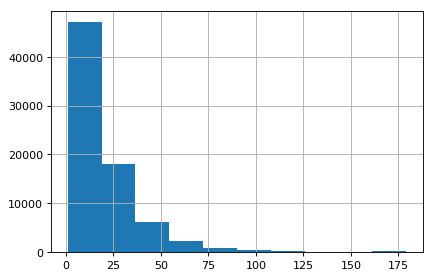

proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_height 217.69467259623946


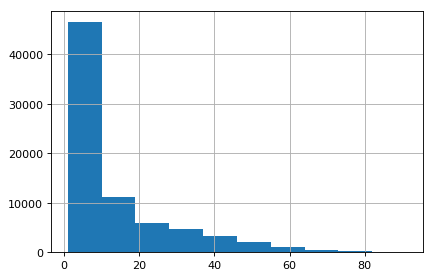

proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width 423.93360246820384


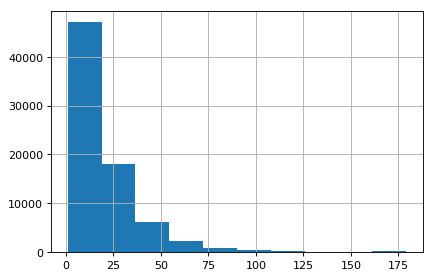

proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_height 217.69467259623946


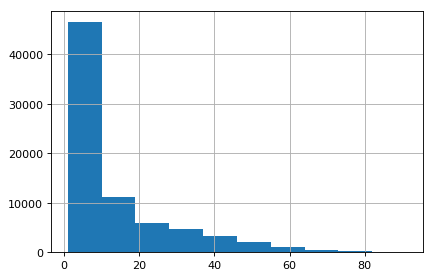

proc1_gtu_x_hough_peak_thr2_major_line_phi 6.940486614527598


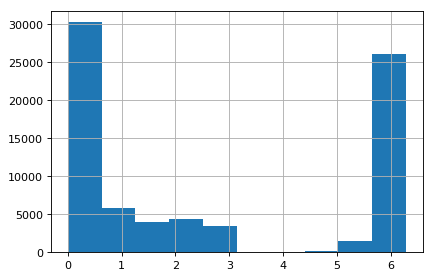

proc1_gtu_x_hough_peak_thr2_major_line_rho 95.9719894449492


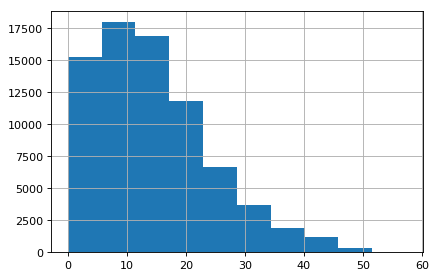

proc1_gtu_x_hough_peak_thr2_max_clu_major_line_phi 7.448375421413703


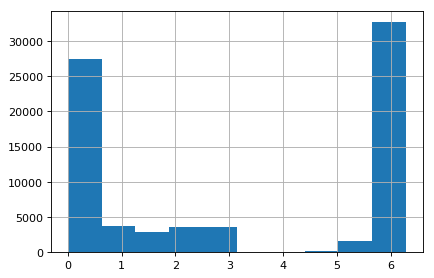

proc1_gtu_x_hough_peak_thr2_max_clu_major_line_rho 88.53896111484642


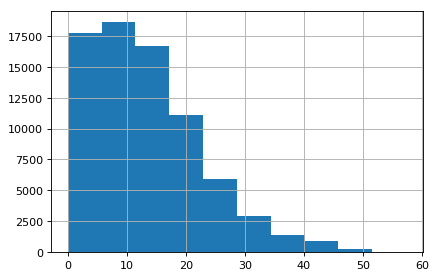

proc1_gtu_x_hough_peak_thr2_line_clusters_count 1.5082552421533155


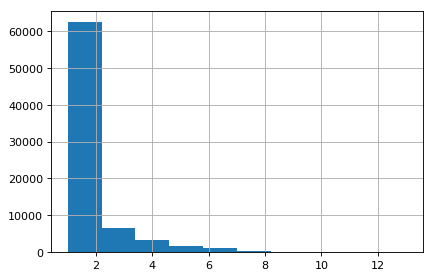

proc1_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_width 263.5235082730321


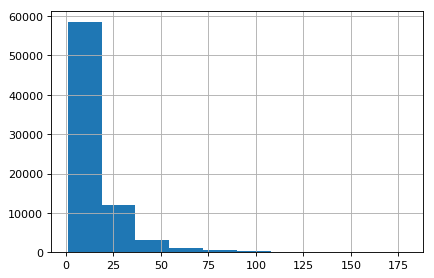

proc1_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_height 147.07714203005014


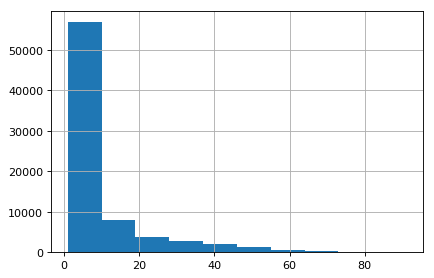

proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width 263.5235082730321


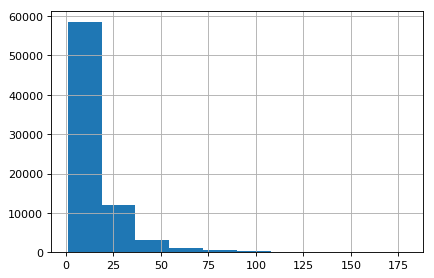

proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_height 147.07714203005014


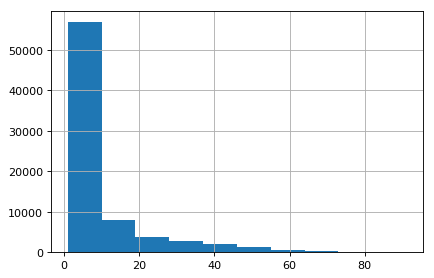

proc1_gtu_x_hough_peak_thr3_major_line_phi 6.934049498884652


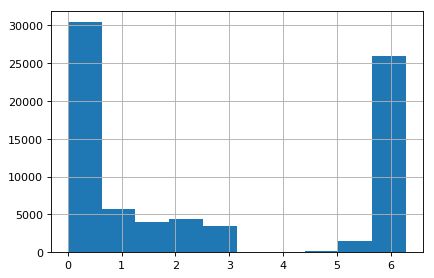

proc1_gtu_x_hough_peak_thr3_major_line_rho 96.8768828014119


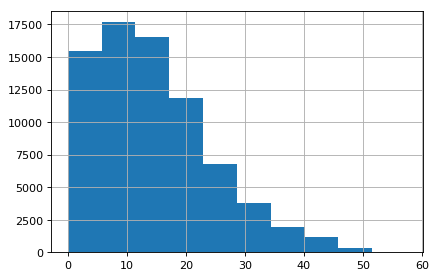

proc1_gtu_x_hough_peak_thr3_max_clu_major_line_phi 7.456076749004573


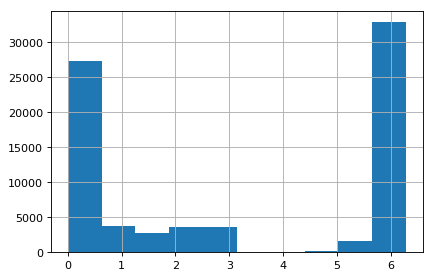

proc1_gtu_x_hough_peak_thr3_max_clu_major_line_rho 88.52737573555146


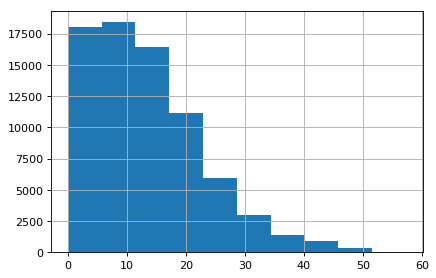

proc1_gtu_x_hough_peak_thr3_line_clusters_count 1.409221766831194


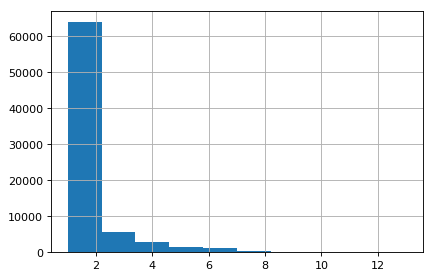

proc1_gtu_x_hough_peak_thr3_line_clusters_max_size_clu_width 217.01717632961422


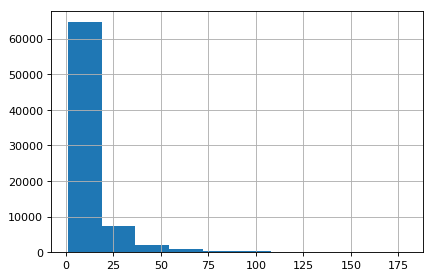

proc1_gtu_x_hough_peak_thr3_line_clusters_max_size_clu_height 100.99451870068225


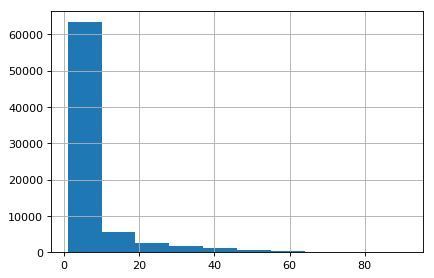

proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width 217.01717632961422


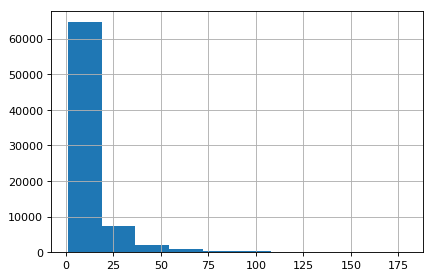

proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_height 100.99451870068225


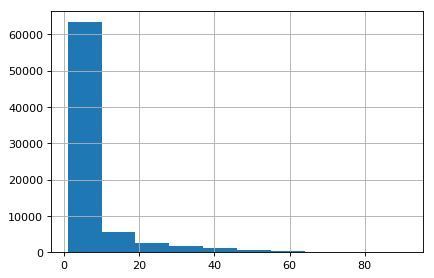

proc1_gtu_y_hough_peak_thr1_major_line_phi 6.878121232329532


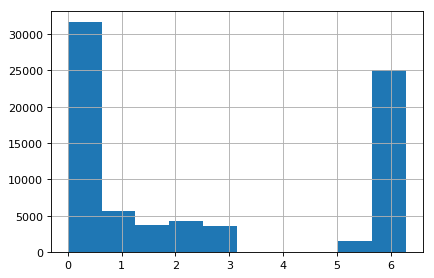

proc1_gtu_y_hough_peak_thr1_major_line_rho 91.16507234941763


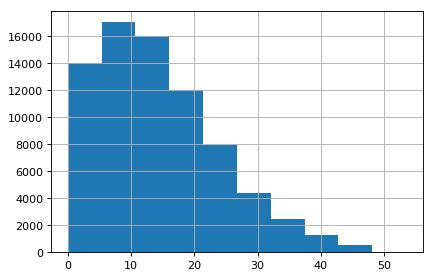

proc1_gtu_y_hough_peak_thr1_max_clu_major_line_phi 7.420820913524084


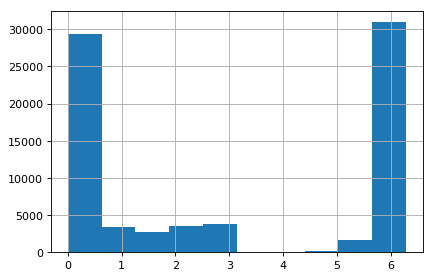

proc1_gtu_y_hough_peak_thr1_max_clu_major_line_rho 86.0423669404182


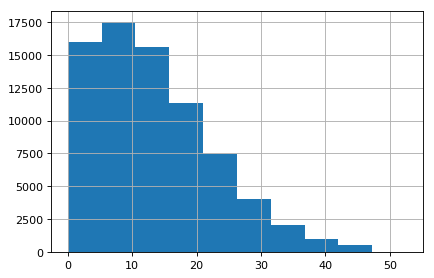

proc1_gtu_y_hough_peak_thr1_line_clusters_count 1.9566267512233528


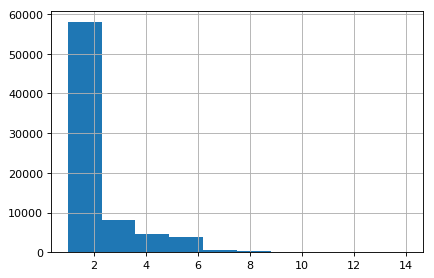

proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width 417.0686731019075


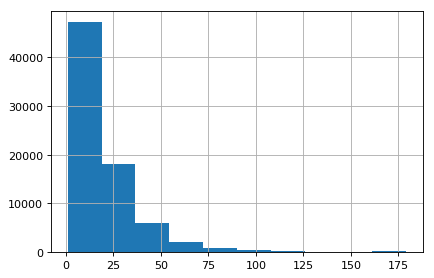

proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height 225.19082451031224


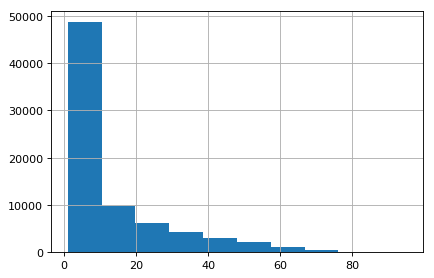

proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width 417.0686731019075


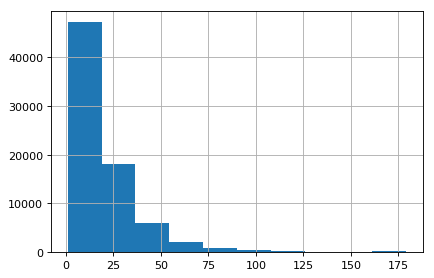

proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_height 225.19082451031224


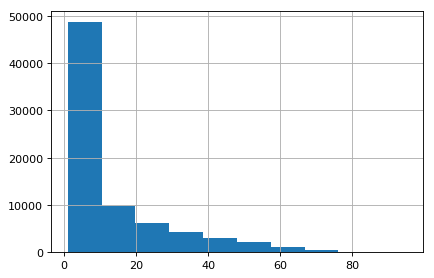

proc1_gtu_y_hough_peak_thr2_major_line_phi 6.869123448930604


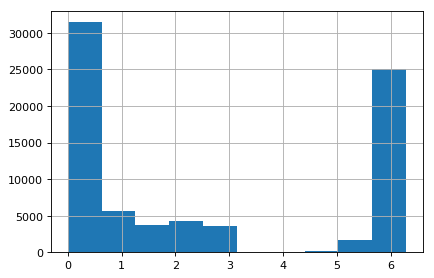

proc1_gtu_y_hough_peak_thr2_major_line_rho 93.18517114886451


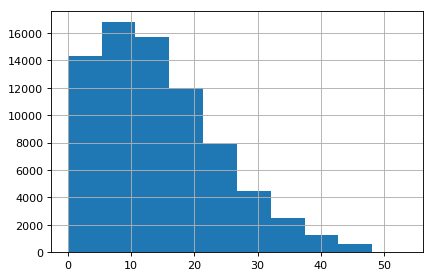

proc1_gtu_y_hough_peak_thr2_max_clu_major_line_phi 7.436156813018531


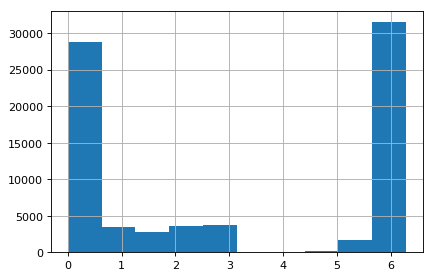

proc1_gtu_y_hough_peak_thr2_max_clu_major_line_rho 86.21440298578159


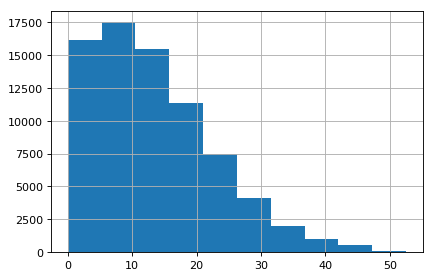

proc1_gtu_y_hough_peak_thr2_line_clusters_count 1.4819557801523824


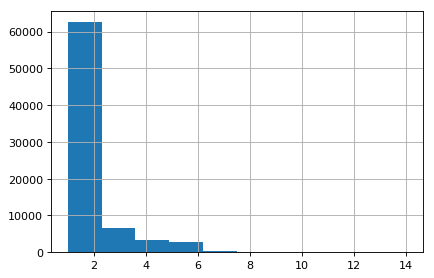

proc1_gtu_y_hough_peak_thr2_line_clusters_max_size_clu_width 259.51419011897957


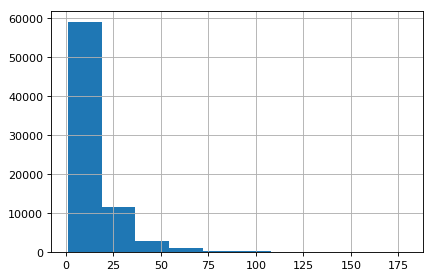

proc1_gtu_y_hough_peak_thr2_line_clusters_max_size_clu_height 152.88041037840392


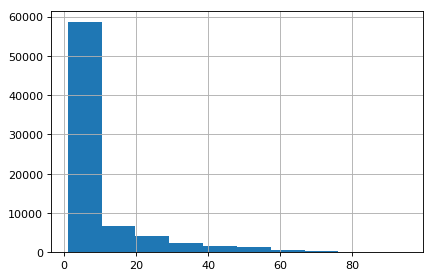

proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width 259.51419011897957


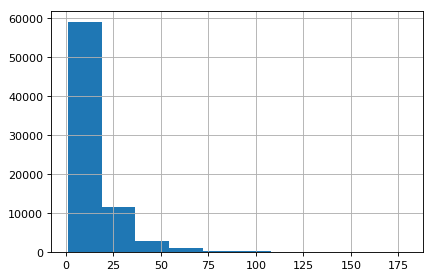

proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_height 152.88041037840392


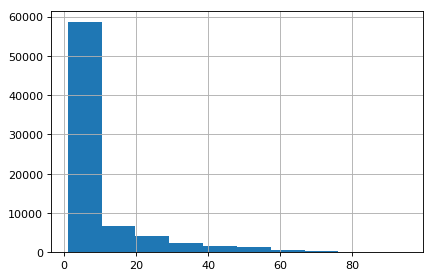

proc1_gtu_y_hough_peak_thr3_major_line_phi 6.863078280521963


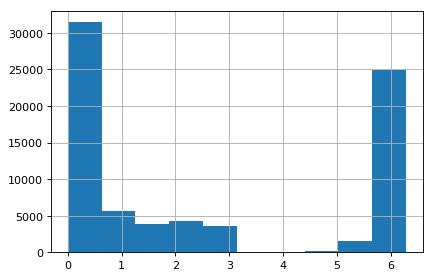

proc1_gtu_y_hough_peak_thr3_major_line_rho 93.92387894483811


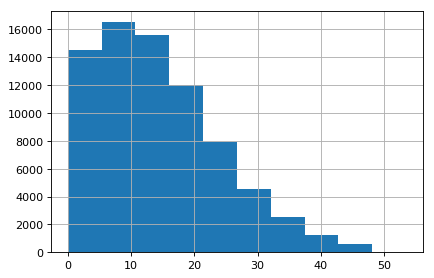

proc1_gtu_y_hough_peak_thr3_max_clu_major_line_phi 7.446017773231403


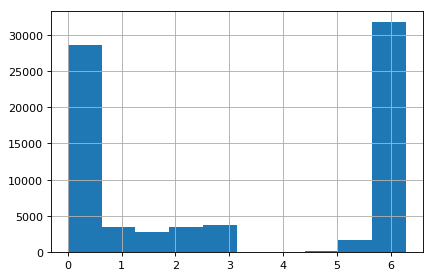

proc1_gtu_y_hough_peak_thr3_max_clu_major_line_rho 86.19953025673908


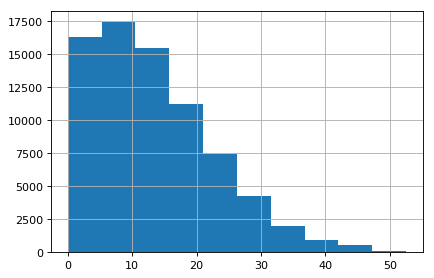

proc1_gtu_y_hough_peak_thr3_line_clusters_count 1.386781479524342


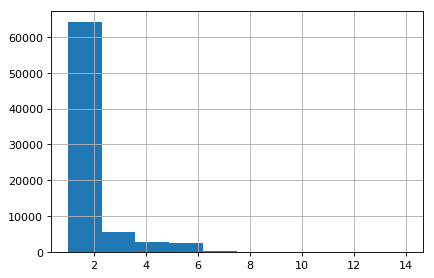

proc1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width 214.84172829491976


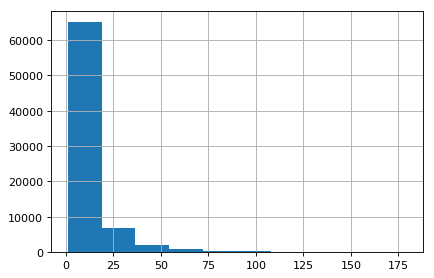

proc1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height 102.17857237189101


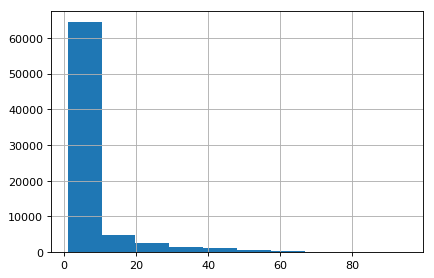

proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width 214.84172829491976


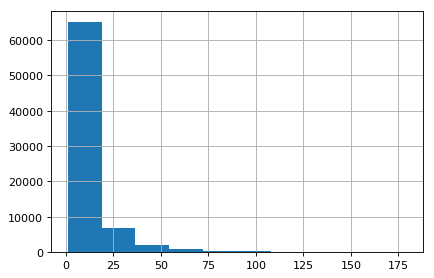

proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height 102.17857237189101


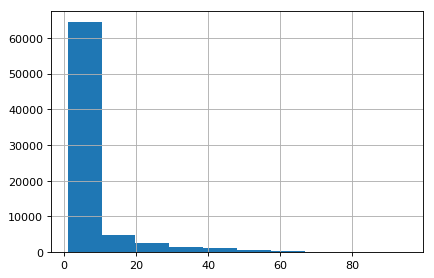

proc1_gtu_y_gtu_x_hough_peak_thr1_major_line_phi_diff 0.185398481749879


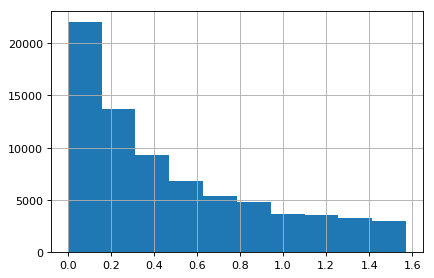

proc1_gtu_y_hough_peak_thr1_major_line_phi_diff_0 0.13903513527356567


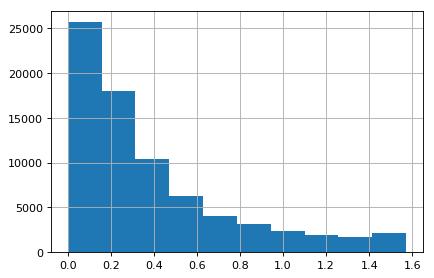

proc1_gtu_y_hough_peak_thr1_major_line_phi_diff_pi_over_2 0.13903513527356567


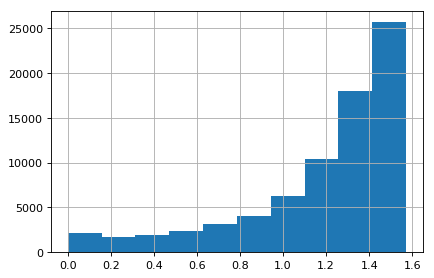

proc1_gtu_x_hough_peak_thr1_major_line_phi_diff_0 0.1450441117701223


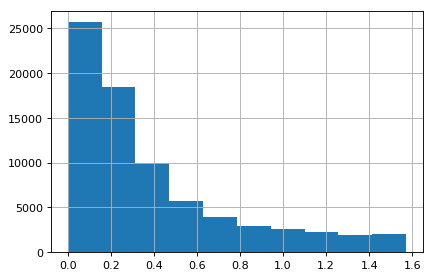

proc1_gtu_x_hough_peak_thr1_major_line_phi_diff_pi_over_2 0.1450441117701223


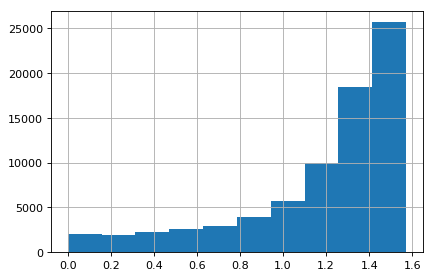

In [12]:
plt.close('all')
for col,col_type in zip(data_df.columns,data_df.dtypes):
    if col_type == object or  data_df[col].var() == 0:
        continue
    print(col, data_df[col].var() )
    data_df[col].hist()
    
    plt.show()

In [13]:
_prev_max_columns = pd.get_option('display.max_columns')
_prev_max_col_width = pd.get_option('display.max_colwidth')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)
data_df

,event_id,source_file_acquisition_full,gtu_in_packet,num_gtu,orig_x_y_max,orig_x_y_mean_gz,proc1_x_y_clusters_count,proc1_x_y_clusters_sizes_max,proc1_x_y_clusters_sizes_mean,proc1_gtu_x_clusters_count,proc1_gtu_x_clusters_sizes_max,proc1_gtu_x_clusters_sizes_mean,proc1_gtu_y_clusters_count,proc1_gtu_y_clusters_sizes_max,proc1_gtu_y_clusters_sizes_mean,proc1_x_y_hough_peak_thr1_major_line_phi,proc1_x_y_hough_peak_thr1_major_line_rho,proc1_x_y_hough_peak_thr1_max_clu_major_line_phi,proc1_x_y_hough_peak_thr1_max_clu_major_line_rho,proc1_x_y_hough_peak_thr1_line_clusters_count,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr2_major_line_phi,proc1_x_y_hough_peak_thr2_major_line_rho,proc1_x_y_hough_peak_thr2_max_clu_major_line_phi,proc1_x_y_hough_peak_thr2_max_clu_major_line_rho,proc1_x_y_hough_peak_thr2_line_clusters_count,proc1_x_y_hough_peak_thr2_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr3_major_line_phi,proc1_x_y_hough_peak_thr3_major_line_rho,proc1_x_y_hough_peak_thr3_max_clu_major_line_phi,proc1_x_y_hough_peak_thr3_max_clu_major_line_rho,proc1_x_y_hough_peak_thr3_line_clusters_count,proc1_x_y_hough_peak_thr3_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_height,proc1_gtu_x_hough_peak_thr1_major_line_phi,proc1_gtu_x_hough_peak_thr1_major_line_rho,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr1_line_clusters_count,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_gtu_x_hough_peak_thr2_major_line_phi,proc1_gtu_x_hough_peak_thr2_major_line_rho,proc1_gtu_x_hough_peak_thr2_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr2_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr2_line_clusters_count,proc1_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_height,proc1_gtu_x_hough_peak_thr3_major_line_phi,proc1_gtu_x_hough_peak_thr3_major_line_rho,proc1_gtu_x_hough_peak_thr3_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr3_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr3_line_clusters_count,proc1_gtu_x_hough_peak_thr3_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_height,proc1_gtu_y_hough_peak_thr1_major_line_phi,proc1_gtu_y_hough_peak_thr1_major_line_rho,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_y_hough_peak_thr1_line_clusters_count,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_gtu_y_hough_peak_thr2_major_line_phi,proc1_gtu_y_hough_peak_thr2_major_line_rho,proc1_gtu_y_hough_peak_thr2_max_clu_major_line_phi,proc1_gtu_y_hough_peak_thr2_max_clu_major_line_rho,proc1_gtu_y_hough_peak_thr2_line_clusters_count,proc1_gtu_y_hough_peak_thr2_line_clusters_max_size_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_

In [14]:
for k, v in data_df.var().iteritems():
    print("{:60s}\t{}".format(k,v))

event_id                                                    	475757243.5
gtu_in_packet                                               	0.0
num_gtu                                                     	0.0
orig_x_y_max                                                	21.93228865901877
orig_x_y_mean_gz                                            	0.6019703799324774
proc1_x_y_clusters_count                                    	3.3677743869169725
proc1_x_y_clusters_sizes_max                                	1713.1325427639601
proc1_x_y_clusters_sizes_mean                               	779.6422377580026
proc1_gtu_x_clusters_count                                  	1.5234142368284322
proc1_gtu_x_clusters_sizes_max                              	714.4049287537215
proc1_gtu_x_clusters_sizes_mean                             	440.9633042940112
proc1_gtu_y_clusters_count                                  	1.5187127301182342
proc1_gtu_y_clusters_sizes_max                              	706.6622928162944
pr

In [16]:
data_w_null_df = data_df[ data_df.isnull().any(axis=1) ]
print(len(data_w_null_df))
data_w_null_df

20


,event_id,source_file_acquisition_full,gtu_in_packet,num_gtu,orig_x_y_max,orig_x_y_mean_gz,proc1_x_y_clusters_count,proc1_x_y_clusters_sizes_max,proc1_x_y_clusters_sizes_mean,proc1_gtu_x_clusters_count,proc1_gtu_x_clusters_sizes_max,proc1_gtu_x_clusters_sizes_mean,proc1_gtu_y_clusters_count,proc1_gtu_y_clusters_sizes_max,proc1_gtu_y_clusters_sizes_mean,proc1_x_y_hough_peak_thr1_major_line_phi,proc1_x_y_hough_peak_thr1_major_line_rho,proc1_x_y_hough_peak_thr1_max_clu_major_line_phi,proc1_x_y_hough_peak_thr1_max_clu_major_line_rho,proc1_x_y_hough_peak_thr1_line_clusters_count,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr2_major_line_phi,proc1_x_y_hough_peak_thr2_major_line_rho,proc1_x_y_hough_peak_thr2_max_clu_major_line_phi,proc1_x_y_hough_peak_thr2_max_clu_major_line_rho,proc1_x_y_hough_peak_thr2_line_clusters_count,proc1_x_y_hough_peak_thr2_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr3_major_line_phi,proc1_x_y_hough_peak_thr3_major_line_rho,proc1_x_y_hough_peak_thr3_max_clu_major_line_phi,proc1_x_y_hough_peak_thr3_max_clu_major_line_rho,proc1_x_y_hough_peak_thr3_line_clusters_count,proc1_x_y_hough_peak_thr3_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_height,proc1_gtu_x_hough_peak_thr1_major_line_phi,proc1_gtu_x_hough_peak_thr1_major_line_rho,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr1_line_clusters_count,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_gtu_x_hough_peak_thr2_major_line_phi,proc1_gtu_x_hough_peak_thr2_major_line_rho,proc1_gtu_x_hough_peak_thr2_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr2_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr2_line_clusters_count,proc1_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_height,proc1_gtu_x_hough_peak_thr3_major_line_phi,proc1_gtu_x_hough_peak_thr3_major_line_rho,proc1_gtu_x_hough_peak_thr3_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr3_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr3_line_clusters_count,proc1_gtu_x_hough_peak_thr3_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_height,proc1_gtu_y_hough_peak_thr1_major_line_phi,proc1_gtu_y_hough_peak_thr1_major_line_rho,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_y_hough_peak_thr1_line_clusters_count,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_gtu_y_hough_peak_thr2_major_line_phi,proc1_gtu_y_hough_peak_thr2_major_line_rho,proc1_gtu_y_hough_peak_thr2_max_clu_major_line_phi,proc1_gtu_y_hough_peak_thr2_max_clu_major_line_rho,proc1_gtu_y_hough_peak_thr2_line_clusters_count,proc1_gtu_y_hough_peak_thr2_line_clusters_max_size_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_

In [17]:
def show_simu_events(data_to_vis_df, nrows=7, ncols=9, vis_xy=True, vis_gtux=True, vis_gtuy=True):
    plt.close('all')

    fig, axs = plt.subplots(nrows, ncols)
    fig.set_size_inches(ncols*5,nrows*5)
    axs_flattened = axs.flatten()
    ai = 0

    for i,(rid,r) in enumerate(data_to_vis_df.iterrows()):
        simu_gtu_start = r['gtu_in_packet']-4-30
        simu_gtu_end = simu_gtu_start+r['num_gtu']

        if ai+2 >= len(axs_flattened):
            break

        print( r['source_file_acquisition_full'], r['source_file_acquisition_full'], "#{} i{}".format(i, r['event_id']), (simu_gtu_start,simu_gtu_end) )
        visualize_simu_event_projections(r['source_file_acquisition_full'], title="#{} i{}".format(i, r['event_id']), axs_flattened=axs_flattened, 
                                        vis_xy=vis_xy, vis_gtux=vis_gtux, vis_gtuy=vis_gtuy, 
                                        ai=ai,
                                        gtu_range=(simu_gtu_start, simu_gtu_end), get_simunpy_func=lambda acq: acq)
        ai += 3

        if ai >= len(axs_flattened):
            break
    plt.show()

/home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_2.00e+12/Ssegv24.2017-07-07-12h53m02s/simu2npy/ev_46_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_2.00e+12/Ssegv24.2017-07-07-12h53m02s/simu2npy/ev_46_mc_1__signals.npy #0 i167388 (-4, 34)
len(event_frames)=49 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=34 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.78e+12/thousnd33E5.2017-07-25-17h20m09s/simu2npy/ev_28_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.78e+12/thousnd33E5.2017-07-25-17h20m09s/simu2npy/ev_28_mc_1__signals.npy #1 i184158 (-4, 34)
len(event_frames)=41 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=34 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_2.82e+12/thousnd33E9/simu2npy/ev_6_mc_1__sign

/home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_6.85e+12/simu.2017-07-23-02h07m59s/simu2npy/ev_23_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_6.85e+12/simu.2017-07-23-02h07m59s/simu2npy/ev_23_mc_1__signals.npy #19 i236738 (-4, 34)
len(event_frames)=84 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=34 event_frames_offset=0


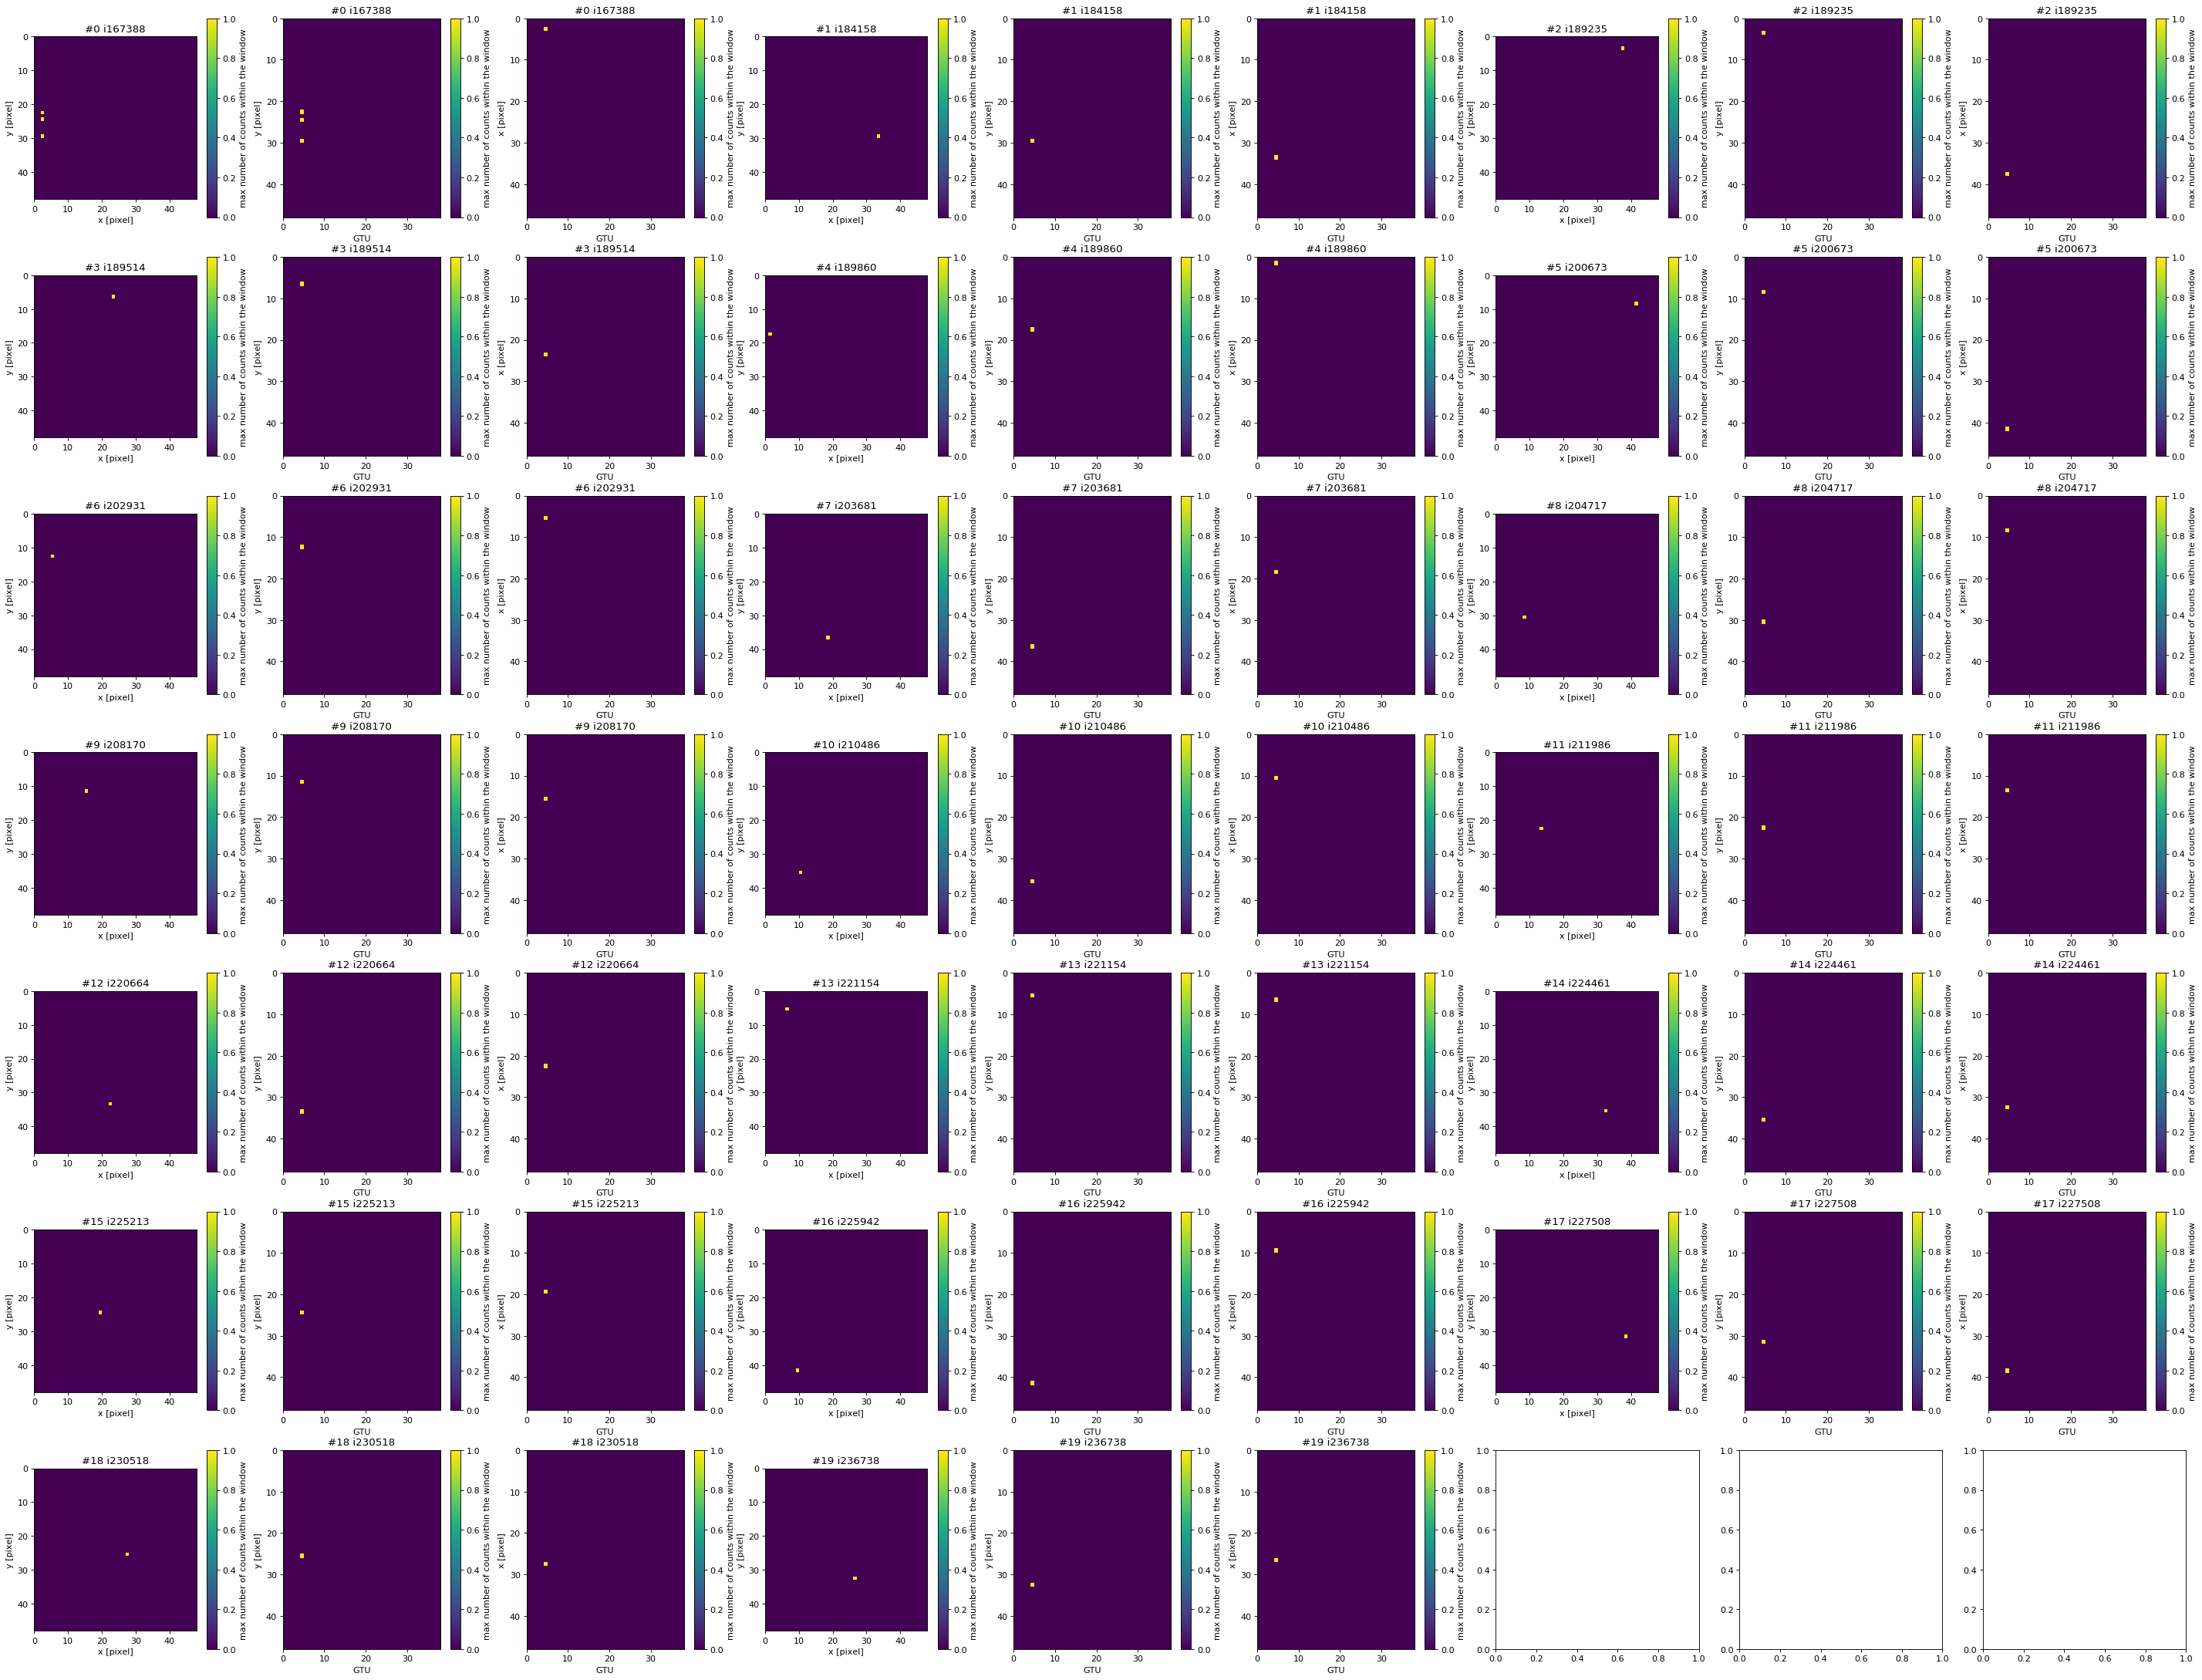

In [18]:
show_simu_events(data_w_null_df)

In [19]:
data_df.describe()

,event_id,gtu_in_packet,num_gtu,orig_x_y_max,orig_x_y_mean_gz,proc1_x_y_clusters_count,proc1_x_y_clusters_sizes_max,proc1_x_y_clusters_sizes_mean,proc1_gtu_x_clusters_count,proc1_gtu_x_clusters_sizes_max,proc1_gtu_x_clusters_sizes_mean,proc1_gtu_y_clusters_count,proc1_gtu_y_clusters_sizes_max,proc1_gtu_y_clusters_sizes_mean,proc1_x_y_hough_peak_thr1_major_line_phi,proc1_x_y_hough_peak_thr1_major_line_rho,proc1_x_y_hough_peak_thr1_max_clu_major_line_phi,proc1_x_y_hough_peak_thr1_max_clu_major_line_rho,proc1_x_y_hough_peak_thr1_line_clusters_count,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr2_major_line_phi,proc1_x_y_hough_peak_thr2_major_line_rho,proc1_x_y_hough_peak_thr2_max_clu_major_line_phi,proc1_x_y_hough_peak_thr2_max_clu_major_line_rho,proc1_x_y_hough_peak_thr2_line_clusters_count,proc1_x_y_hough_peak_thr2_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr3_major_line_phi,proc1_x_y_hough_peak_thr3_major_line_rho,proc1_x_y_hough_peak_thr3_max_clu_major_line_phi,proc1_x_y_hough_peak_thr3_max_clu_major_line_rho,proc1_x_y_hough_peak_thr3_line_clusters_count,proc1_x_y_hough_peak_thr3_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_height,proc1_gtu_x_hough_peak_thr1_major_line_phi,proc1_gtu_x_hough_peak_thr1_major_line_rho,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr1_line_clusters_count,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_gtu_x_hough_peak_thr2_major_line_phi,proc1_gtu_x_hough_peak_thr2_major_line_rho,proc1_gtu_x_hough_peak_thr2_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr2_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr2_line_clusters_count,proc1_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_height,proc1_gtu_x_hough_peak_thr3_major_line_phi,proc1_gtu_x_hough_peak_thr3_major_line_rho,proc1_gtu_x_hough_peak_thr3_max_clu_major_line_phi,proc1_gtu_x_hough_peak_thr3_max_clu_major_line_rho,proc1_gtu_x_hough_peak_thr3_line_clusters_count,proc1_gtu_x_hough_peak_thr3_line_clusters_max_size_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_size_clu_height,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_height,proc1_gtu_y_hough_peak_thr1_major_line_phi,proc1_gtu_y_hough_peak_thr1_major_line_rho,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_phi,proc1_gtu_y_hough_peak_thr1_max_clu_major_line_rho,proc1_gtu_y_hough_peak_thr1_line_clusters_count,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_gtu_y_hough_peak_thr2_major_line_phi,proc1_gtu_y_hough_peak_thr2_major_line_rho,proc1_gtu_y_hough_peak_thr2_max_clu_major_line_phi,proc1_gtu_y_hough_peak_thr2_max_clu_major_line_rho,proc1_gtu_y_hough_peak_thr2_line_clusters_count,proc1_gtu_y_hough_peak_thr2_line_clusters_max_size_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_size_clu_height,proc1_gtu

In [20]:
pd.set_option('display.max_columns', _prev_max_columns)
pd.set_option('display.max_colwidth', _prev_max_col_width)

In [21]:
def filter_events(data_df):    
    limited_max_peak_df = data_df[
        (
            (
                (
                    ((data_df['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40) & (data_df['proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40)) | \
                    ((data_df['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40) & (data_df['proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40)) | \
                    ((data_df['proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40) & (data_df['proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40))
                ) & \
                (data_df['orig_x_y_max'] > 1) #& \
            ) | \
            (data_df['orig_x_y_max'] > 5)
    #     (simu_signals_all_df['trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width'] == 89)
#         (data_df['proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width'] > 60) #& \
    #     (simu_signals_all_df['proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] == 179)
        # 179 should be rerun
        )
    ].sort_values(
        ['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width','proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width','proc1_x_y_clusters_count'],
    #     ascending=[False,False,False]
        ascending=[True,True,True]
    )
    return limited_max_peak_df
    
limited_max_peak_df = filter_events(data_df)

In [22]:
len(limited_max_peak_df)

17655

In [89]:
t_selector = ~(
    ((limited_max_peak_df['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40) & \
     (limited_max_peak_df['proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40)) | \
    ((limited_max_peak_df['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40) & \
     (limited_max_peak_df['proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40)) | \
    ((limited_max_peak_df['proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40) & \
     (limited_max_peak_df['proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width'] < 40))
) \
& (limited_max_peak_df['orig_x_y_max'] < 10) \
& (limited_max_peak_df['proc1_x_y_clusters_sizes_max'] > 20) \
& (limited_max_peak_df['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height'] > 60)
# 
# t_selector = 

In [90]:
data_to_vis_df = limited_max_peak_df[ t_selector ].sort_values(
    by='orig_x_y_max',ascending=True) # proc1_x_y_clusters_sizes_max

In [91]:
print('{:30s}  {}'.format('len(data_to_vis_df)',len(data_to_vis_df)))
print('{:30s}  {}'.format('len(limited_max_peak_df)',len(limited_max_peak_df)))

len(data_to_vis_df)             147
len(limited_max_peak_df)        17655


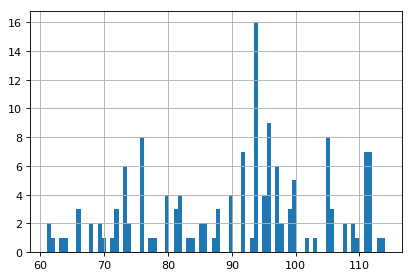

In [92]:
data_to_vis_df['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height'].hist(bins=80)
plt.show()

In [95]:
# data_to_vis_df = limited_max_peak_df.sort_values(by='proc1_x_y_clusters_sizes_max',ascending=False).iloc[20:]
# for i, v in enumerate(data_to_vis_df['proc1_x_y_clusters_sizes_max'].head(50)):
#     print (i, v)
data_to_vis_df[['event_id',
                'orig_x_y_max',
                'orig_x_y_mean_gz',
                'proc1_x_y_clusters_sizes_max', 
                'proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height',
               'proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width',
               'proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width',
               'proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width',
               'orig_x_y_max',
               'proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width',
               'proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width',
               'proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width',
               'proc1_x_y_clusters_count'
              ]]

,event_id,orig_x_y_max,orig_x_y_mean_gz,proc1_x_y_clusters_sizes_max,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,orig_x_y_max,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_x_y_clusters_count
9478,175266,6,1.32353,23,97.0,40.0,98.0,23.0,6,40.0,12.0,6.0,5
3942,169730,6,1.38182,49,93.0,166.0,55.0,55.0,6,166.0,129.0,40.0,5
11747,177535,6,1.42553,41,80.0,179.0,39.0,59.0,6,179.0,147.0,32.0,6
907,166695,6,1.50000,26,96.0,79.0,104.0,39.0,6,79.0,34.0,18.0,1
5403,171191,6,1.32143,54,103.0,179.0,39.0,47.0,6,179.0,70.0,28.0,3
22220,188008,6,2.24242,31,92.0,52.0,48.0,22.0,6,52.0,44.0,28.0,3
3903,169691,6,1.66667,33,100.0,176.0,81.0,80.0,6,176.0,123.0,30.0,6
2269,168057,6,1.55172,26,88.0,165.0,50.0,174.0,6,165.0,106.0,14.0,3
8585,174373,6,1.21782,100,95.0,53.0,52.0,21.0,6,53.0,32.0,13.0,2
9141,174929,6,1.32500,32,102.0,58.0,146.0,67.0,6,58.0,17.0,7.0,4


/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_5.62e+12/thousnd18E15.2017-07-28-11h06m51s/simu2npy/ev_89_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_5.62e+12/thousnd18E15.2017-07-28-11h06m51s/simu2npy/ev_89_mc_1__signals.npy #0 i175266 (-4, 34)
len(event_frames)=37 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=34 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_2.88e+12/simu.2017-07-16-13h32m36s/simu2npy/ev_25_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_2.88e+12/simu.2017-07-16-13h32m36s/simu2npy/ev_25_mc_1__signals.npy #1 i169730 (-4, 34)
len(event_frames)=22 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=22 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_8.91e+12/thousnd33E19.2017-07-26-13h42m49s/simu2n

/home/spbproc/SPBDATA_processed/spb_simu/posz_21000000.00/energy_7.08e+12/thousnd21E17.2017-07-28-11h10m55s/simu2npy/ev_62_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_21000000.00/energy_7.08e+12/thousnd21E17.2017-07-28-11h10m55s/simu2npy/ev_62_mc_1__signals.npy #20 i170274 (-4, 34)
len(event_frames)=23 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=23 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_2.82e+12/thousnd30E9.2017-07-25-03h33m01s/simu2npy/ev_10_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_2.82e+12/thousnd30E9.2017-07-25-03h33m01s/simu2npy/ev_10_mc_1__signals.npy #21 i174453 (-4, 34)
len(event_frames)=25 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=25 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_8.91e+12/thousnd30E19.2017-07-25-

/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_3.82e+12/simu.2017-07-17-23h14m13s/simu2npy/ev_64_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_3.82e+12/simu.2017-07-17-23h14m13s/simu2npy/ev_64_mc_1__signals.npy #39 i172535 (-4, 34)
len(event_frames)=26 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=26 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_7.94e+12/thousnd30E18.2017-07-25-17h24m17s/simu2npy/ev_28_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_7.94e+12/thousnd30E18.2017-07-25-17h24m17s/simu2npy/ev_28_mc_1__signals.npy #40 i206617 (-4, 34)
len(event_frames)=31 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=31 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_27000000.00/energy_5.62e+12/thousnd27E15.2017-07-25-09h22m35s/simu

/home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_5.01e+12/thousnd30E14.2017-07-25-10h18m07s/simu2npy/ev_48_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_5.01e+12/thousnd30E14.2017-07-25-10h18m07s/simu2npy/ev_48_mc_1__signals.npy #58 i175726 (-4, 34)
len(event_frames)=22 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=22 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_7.08e+12/thousnd30E17.2017-07-25-15h24m32s/simu2npy/ev_48_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_7.08e+12/thousnd30E17.2017-07-25-15h24m32s/simu2npy/ev_48_mc_1__signals.npy #59 i176778 (-4, 34)
len(event_frames)=24 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=24 event_frames_offset=0


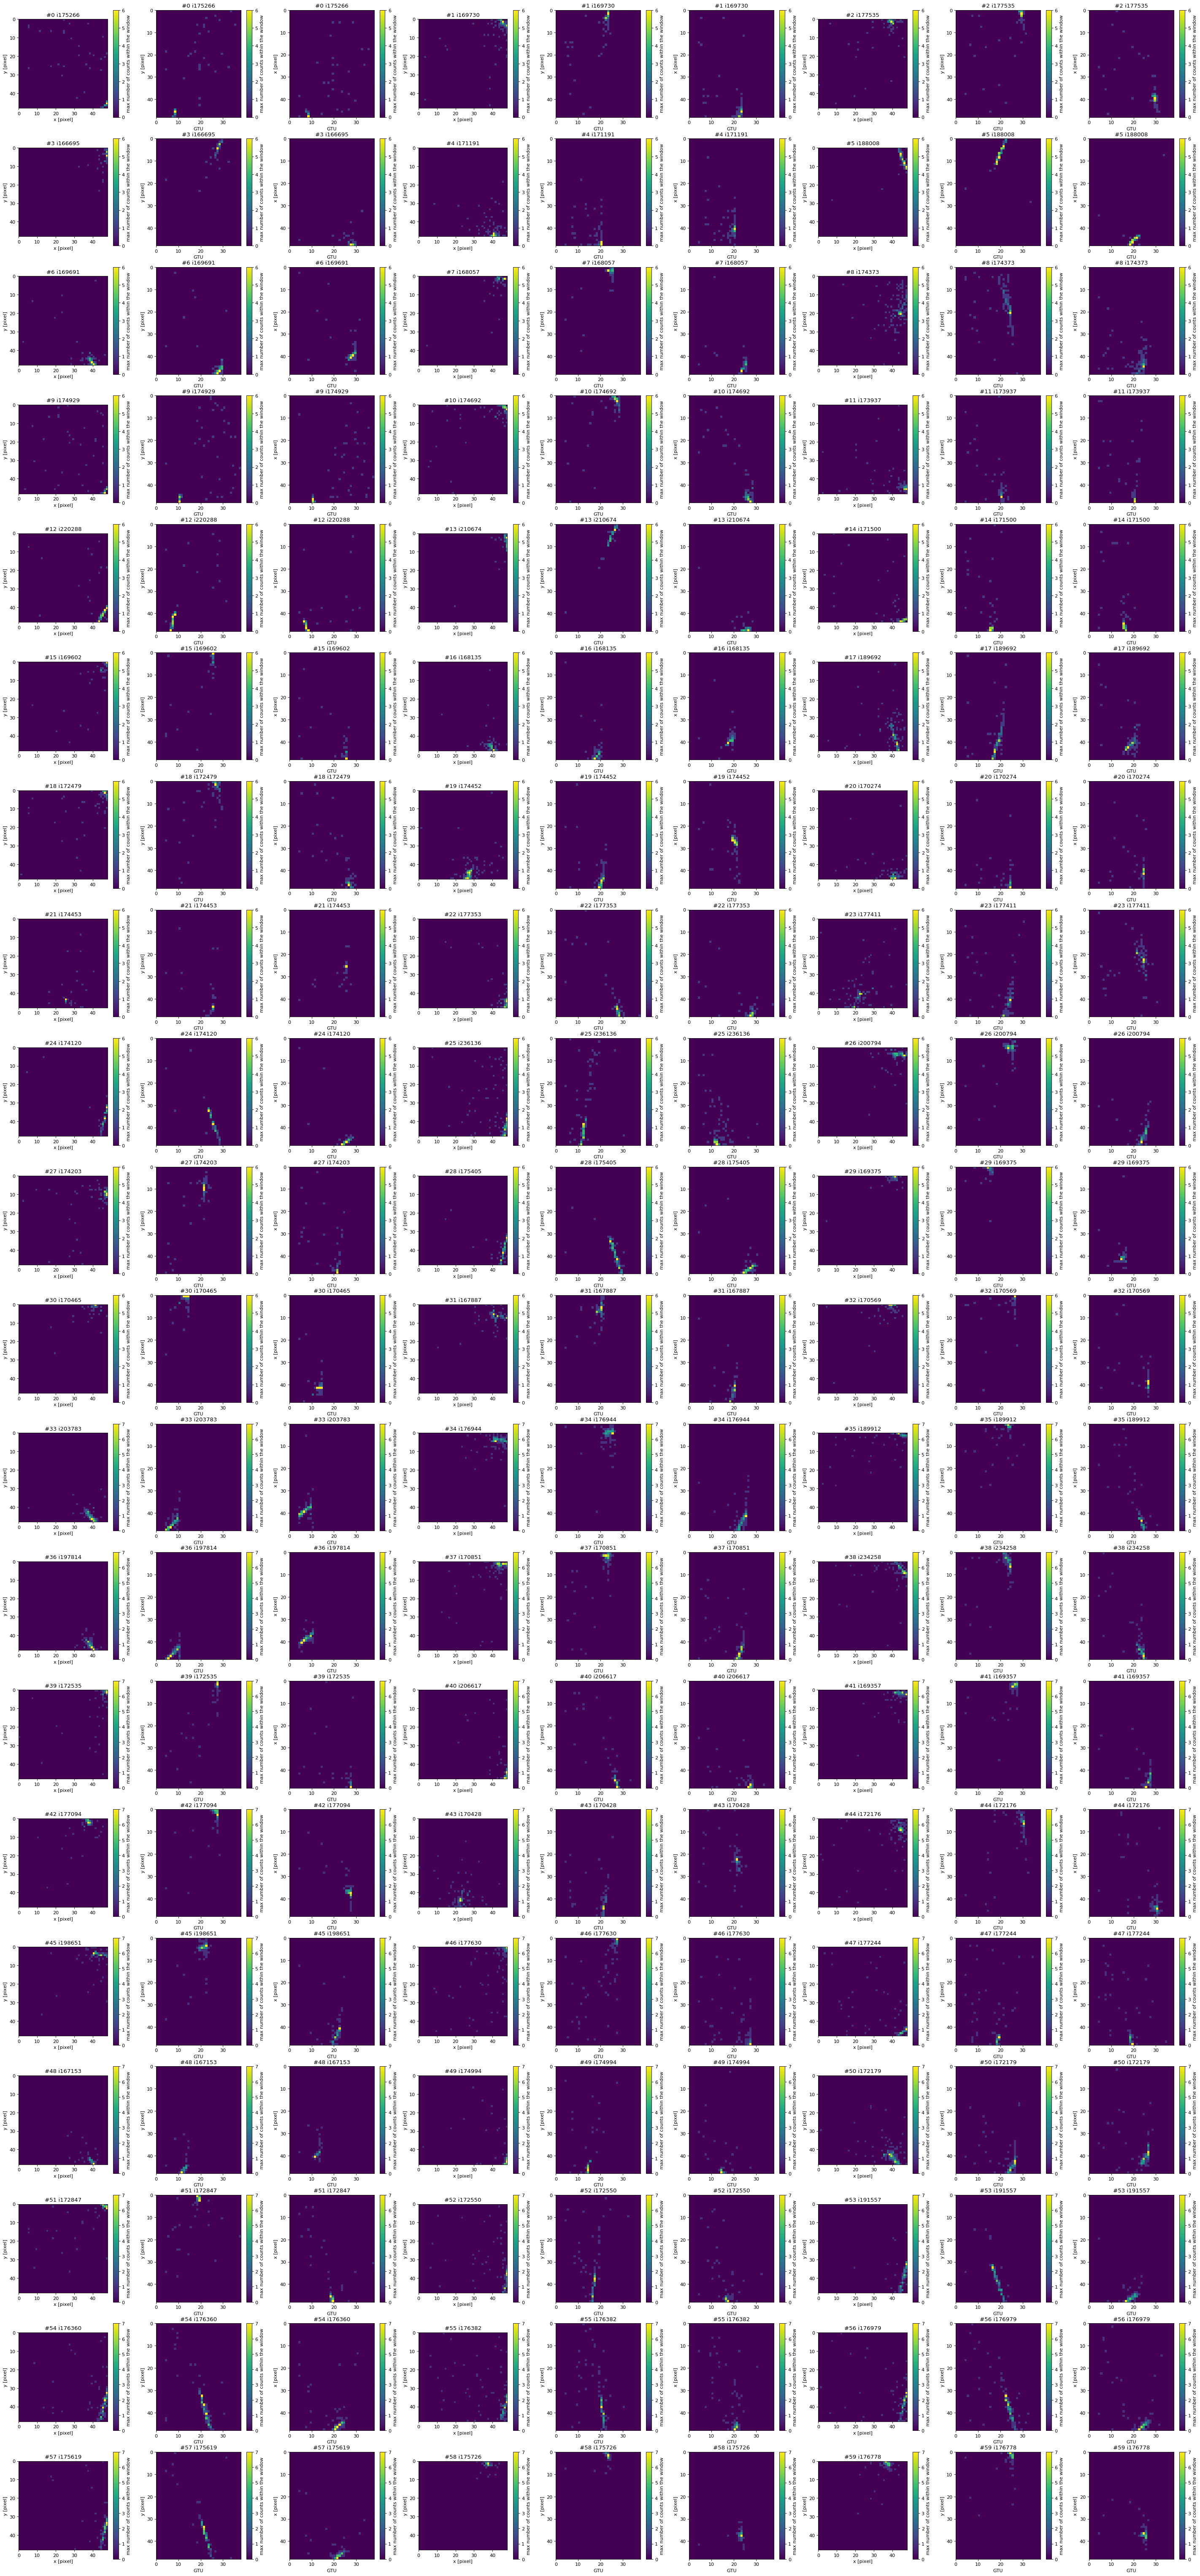

In [94]:
show_simu_events(data_to_vis_df,nrows=20)

In [97]:
# 11198 
for k,v in limited_max_peak_df[ limited_max_peak_df['event_id']==38155 ].iteritems():
#     print(v.values)
    print("{:70s} {}".format(k,v.values))

event_id                                                               [38155]
source_file_acquisition_full                                           ['/home/spbproc/SPBDATA_processed/spb_simu/posz_30000000.00/energy_7.08e+12/thousnd30E17.2017-07-25-16h06m15s/simu2npy/ev_10_mc_1__signals.npy']
gtu_in_packet                                                          [30]
num_gtu                                                                [38]
orig_x_y_max                                                           [4]
proc1_x_y_clusters_count                                               [4]
proc1_x_y_clusters_sizes_mean                                          [17.25]
proc1_gtu_x_clusters_count                                             [2]
proc1_gtu_x_clusters_sizes_mean                                        [24.5]
proc1_gtu_y_clusters_count                                             [3]
proc1_gtu_y_clusters_sizes_mean                                        [15.]
proc1_x_y_hough_pea

In [66]:
dropped_data_columns = ['event_id','gtu_in_packet','source_file_acquisition_full']
data_variances = data_df.var()
for k,v in data_variances.iteritems():
    if v == 0:
        dropped_data_columns.append(k)
print(dropped_data_columns)

['event_id', 'gtu_in_packet', 'source_file_acquisition_full', 'gtu_in_packet', 'num_gtu']


In [67]:
data_for_clustering_df = data_df.drop(dropped_data_columns,axis=1).dropna()

In [68]:
import sklearn
import sklearn.preprocessing

In [69]:
def scale_data(X, scaler_picke_pathname, pickle_overwrite=False, scaler_class=sklearn.preprocessing.StandardScaler):
    scaler = None

    if scaler_picke_pathname:
        if isinstance(scaler_picke_pathname, str) and os.path.isdir(scaler_picke_pathname):
            print('Calculating hash of data ...')
            data_md5 = hashlib.md5(pickle.dumps(X, protocol=0))
            scaler_picke_pathname = os.path.join(scaler_picke_pathname, 'scaler_for_{}.joblib.pkl'.format(data_md5.hexdigest()))

        if os.path.exists(scaler_picke_pathname) and not pickle_overwrite:
            print("Loading existing scaler...")
            scaler = sklearn.externals.joblib.load(scaler_picke_pathname)

    if not scaler:
        print('StandardScaler - fitting and transforming data ...')
        scaler = scaler_class()

        if scaler_picke_pathname:
            print("Saving scaled data into file {}".format(scaler_picke_pathname))
            sklearn.externals.joblib.dump(scaler, scaler_picke_pathname)

        X = scaler_class().fit_transform(X)
    else:
        print('Scaler - transforming data ...')
        X = scaler.transform(X)

    return X

In [70]:
scaled_data = scale_data(data_for_clustering_df.values, None)

StandardScaler - fitting and transforming data ...


In [71]:
scaled_data

array([[ 1.31448273, -0.68048515,  0.49633784, ..., -0.6452943 ,
        -0.59695147, -0.59276591],
       [-0.39357404,  0.40965922, -0.34162076, ...,  1.49941512,
        -0.44852719,  0.34017192],
       [-0.39357404, -0.13541297, -0.39891708, ..., -0.6452943 ,
        -0.44852719, -0.39285066],
       ...,
       [-0.39357404,  0.40965922, -0.37743096, ..., -0.6452943 ,
        -0.59695147, -0.59276591],
       [-0.39357404, -0.13541297, -0.38996453, ...,  0.78451198,
        -0.41142112, -0.25957383],
       [ 0.03344016, -0.13541297,  0.16509352, ..., -0.6452943 ,
        -0.52273933, -0.59276591]])

In [72]:
import sklearn.cluster
import sklearn.decomposition

In [73]:
# decomp_pca = sklearn.decomposition.PCA(n_components=100,svd_solver='randomized')
decomp_pca = sklearn.decomposition.PCA(n_components=None,svd_solver='full')
scaled_data_pca = decomp_pca.fit_transform(scaled_data)

In [74]:
scaled_data_pca

array([[ 1.32667197, -1.38814708, -1.09017084, ...,  0.80466039,
         0.09781071, -0.31455611],
       [-0.89088699, -0.4351485 , -2.05814392, ...,  0.31218711,
         0.30090615, -0.00366113],
       [-0.9358139 ,  0.46728371, -1.04024982, ...,  1.10947588,
        -0.06437281, -0.20795378],
       ...,
       [-0.56309249, -0.07496822, -1.12279614, ...,  0.48386536,
         0.22642772,  0.0275854 ],
       [-0.786295  , -1.56999935, -1.41805949, ...,  0.35373313,
         0.14114278, -0.14343206],
       [ 0.8649468 ,  3.24345294,  1.31679487, ...,  1.17694734,
        -0.22994456, -0.0568731 ]])

In [75]:
cluster_dbscan_scaled_pca = sklearn.cluster.DBSCAN(eps=0.1, min_samples=10).fit(scaled_data)
print( np.max(cluster_dbscan_scaled_pca.labels_) )

-1


In [76]:
# cluster_minibatch_scaled = sklearn.cluster.MiniBatchKMeans(n_clusters=2).fit(scaled_data)
# print(np.max(cluster_minibatch_scaled.labels_))
# print('ones:\t',np.count_nonzero(cluster_minibatch_scaled.labels_))
# print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_minibatch_scaled.labels_))

In [77]:
cluster_kmeans_scaled = sklearn.cluster.KMeans(n_clusters=2).fit(scaled_data)
print(np.max(cluster_kmeans_scaled.labels_))
print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_kmeans_scaled.labels_))
print('ones:\t',np.count_nonzero(cluster_kmeans_scaled.labels_))

1
zeros:	 11474
ones:	 64064


In [78]:
cluster_kmeans_scaled_pca = sklearn.cluster.KMeans(n_clusters=2).fit(scaled_data_pca)
print(np.max(cluster_kmeans_scaled_pca.labels_))
print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_kmeans_scaled_pca.labels_))
print('ones:\t',np.count_nonzero(cluster_kmeans_scaled_pca.labels_))

1
zeros:	 11476
ones:	 64062


In [79]:
# cluster_agglomerative_scaled = sklearn.cluster.AgglomerativeClustering(n_clusters=2,linkage='ward').fit(scaled_data)
# print(np.max(cluster_agglomerative_scaled.labels_))
# print('ones:\t',np.count_nonzero(cluster_agglomerative_scaled.labels_))
# print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_agglomerative_scaled.labels_))

In [80]:
# TAKES TOO LONG
# cluster_spectral_scaled = sklearn.cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack',affinity="nearest_neighbors").fit(scaled_data)
# print(np.max(cluster_kmeans_scaled.labels_))
# print('ones:\t',np.count_nonzero(cluster_spectral_scaled.labels_))
# print('zeros:\t',len(scaled_data)-np.count_nonzero(cluster_spectral_scaled.labels_))

In [89]:
clustered_to_vis = cluster_kmeans_scaled

In [90]:
data_df['cluster_kmeans_label'] = -1
data_df.loc[ ~data_df.isnull().any(axis=1), 'cluster_kmeans_label' ] = clustered_to_vis.labels_


In [91]:
data_df_kmeans_clu_0 = data_df[ data_df['cluster_kmeans_label'] == 0 ].sort_values(
    by=['proc1_x_y_max','proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width'],
    ascending=[False, True])
data_df_kmeans_clu_1 = data_df[ data_df['cluster_kmeans_label'] == 1 ].sort_values(
    by=['proc1_x_y_max','proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width'],
    ascending=[False, True])

/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_3.35e+12/simu.2017-07-17-05h07m34s/simu2npy/ev_18_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_3.35e+12/simu.2017-07-17-05h07m34s/simu2npy/ev_18_mc_1__signals.npy #0 i171740 (-4, 34)
len(event_frames)=24 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=24 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_21000000.00/energy_8.91e+12/thousnd21E19.2017-07-28-16h10m59s/simu2npy/ev_70_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_21000000.00/energy_8.91e+12/thousnd21E19.2017-07-28-16h10m59s/simu2npy/ev_70_mc_1__signals.npy #1 i48740 (-4, 34)
len(event_frames)=30 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=30 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_6.85e+12/simu.2017-07-22-20h27m06s/simu2npy/ev_93_

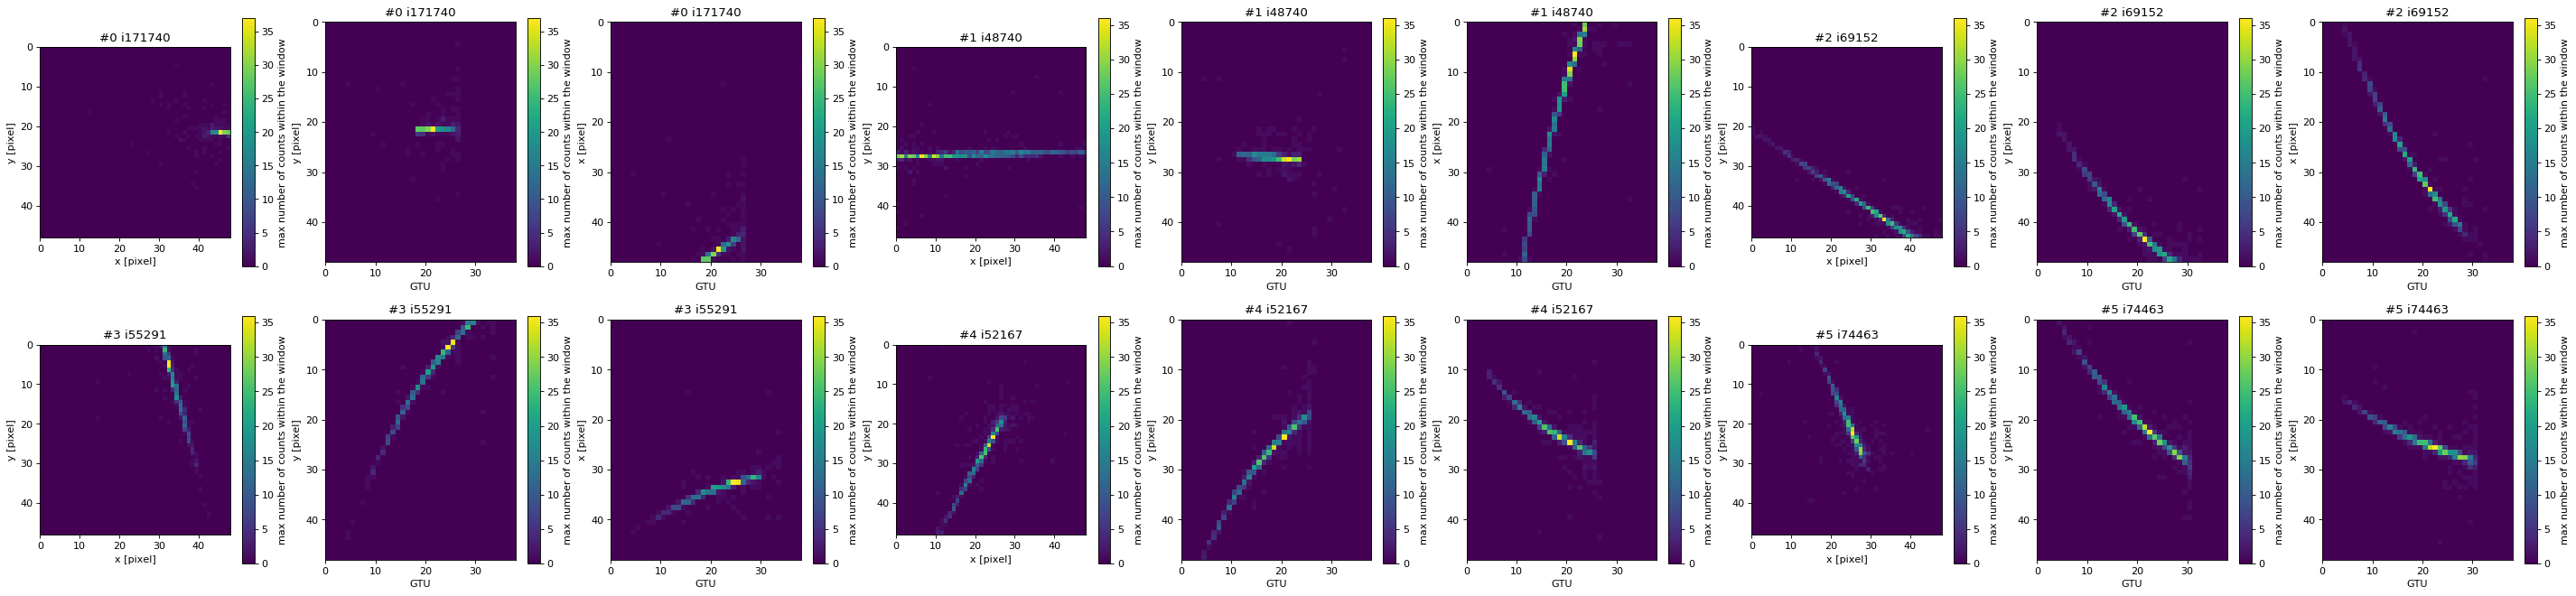

In [92]:
show_simu_events( data_df_kmeans_clu_0.iloc[100:] , 2 )

/home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_6.20e+12/simu.2017-07-22-03h49m26s/simu2npy/ev_8_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_18000000.00/energy_6.20e+12/simu.2017-07-22-03h49m26s/simu2npy/ev_8_mc_1__signals.npy #0 i58771 (-4, 34)
len(event_frames)=26 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=26 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_7.75e+12/simu.2017-07-24-04h18m24s/simu2npy/ev_20_mc_1__signals.npy /home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_7.75e+12/simu.2017-07-24-04h18m24s/simu2npy/ev_20_mc_1__signals.npy #1 i72893 (-4, 34)
len(event_frames)=32 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=32 event_frames_offset=0
/home/spbproc/SPBDATA_processed/spb_simu/posz_24000000.00/energy_7.75e+12/simu.2017-07-24-02h51m07s/simu2npy/ev_82_mc_1__signals.npy /

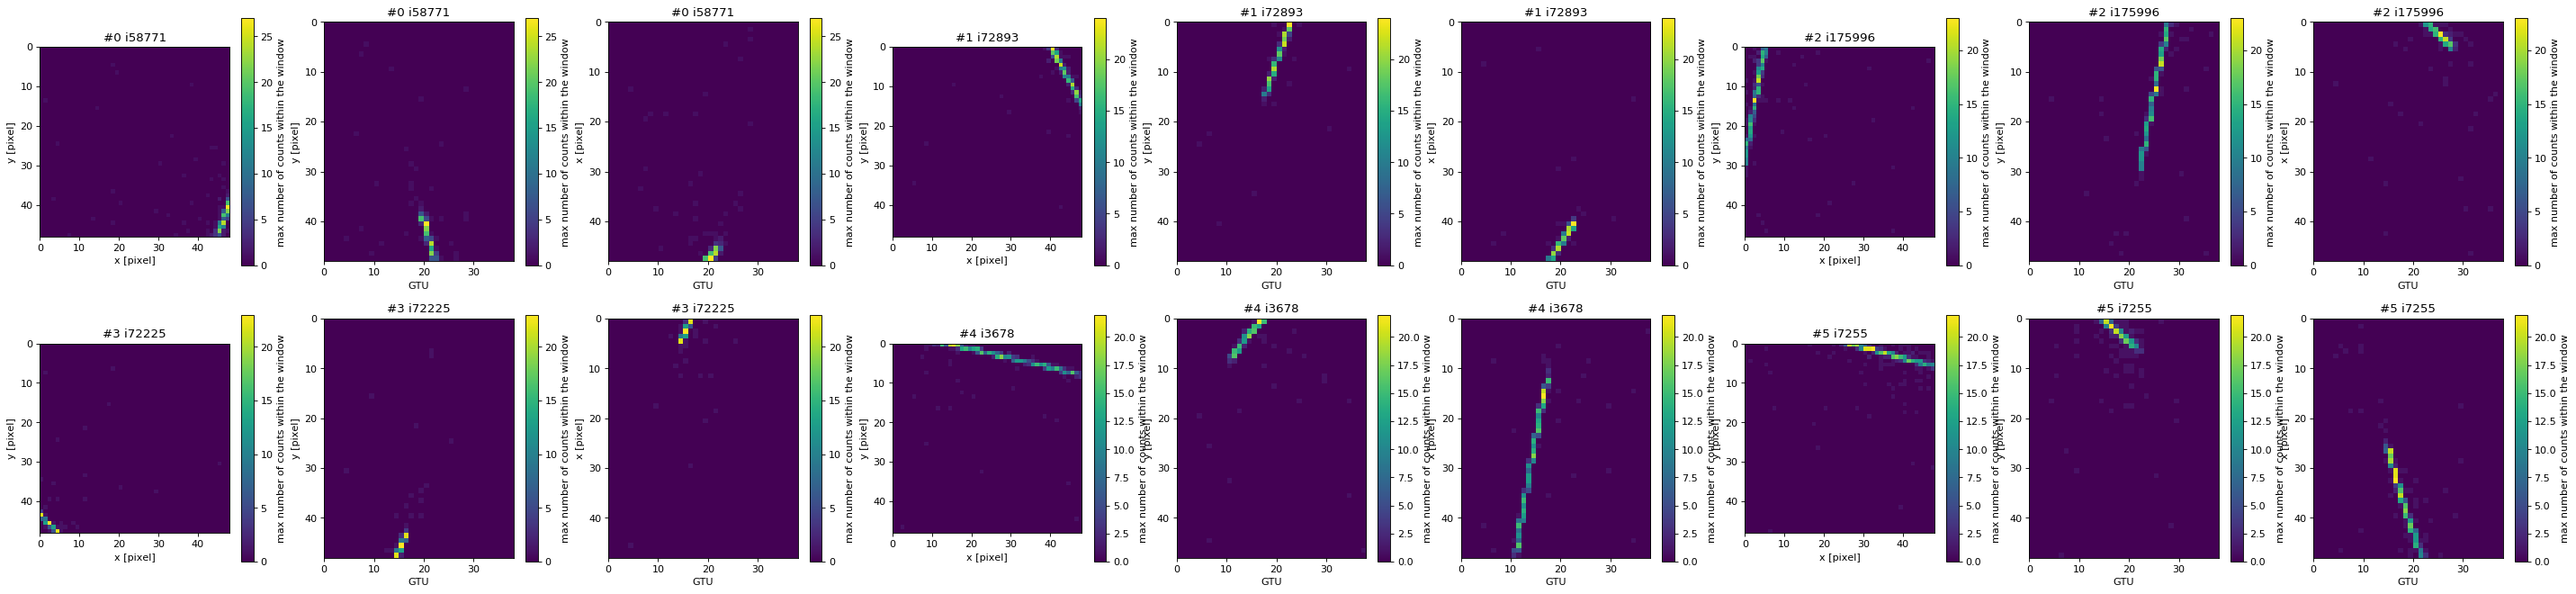

In [93]:
show_simu_events( data_df_kmeans_clu_1.iloc[0:] , 2 )